In [2]:
import pandas as pd
import numpy as np
from lxml import etree

In [3]:
xml_positions = etree.parse('C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003BEU.xml') ##arbeitsplatop

In [2]:
xml_positions = etree.parse('C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003BEU.xml') ##privat

In [4]:
xml_positions

In [5]:
def get_tracking_data(xml_positions, half='firstHalf'):
        """Returns a dataframe with the tracking (position: x, y, z) of all players + the ball
        
        Dropping rows where ball positions is NAN

        +-------+-----------+-----------+
        |       |   BALL    |  TeamId   |
        +       +-----------+-----------+
        |       |  BallId   | PlayerId  |
        + N | T +---+---+---+---+---+---+
        |       | X | Y | Z | X | Y | A |
        +=======+===+===+===+===+===+===+
        | 0 | 0 |123|456|789|012|456|789|
        +-------+-----------+-----------+

        :param xml_positions: the parsed xml tracking data (lxml object)
        :param half: the description of the half: either "firstHalf" or "secondHalf", etc.
        :return: a dataframe containing the tracking data: position of all players and the ball
        """
        def change_type(df, frameset):
            """
            change type of columns
            different columns names and tpyes for the ball and for the rest of the players
            """
            if frameset.attrib.get('TeamId') == 'BALL':
                return df.astype(
                    # change types of columns for the ball
                    dtype={
                        'A':float, 
                        'D':float, 
                        'M':int, 
                        'N':int, 
                        'S':float, 
                        'X':float, 
                        'Y':float,
                        'Z':float,
                        #'T':'datetime64[ns]', # this breaks the timezone
                        'BallPossession':int, 
                        'BallStatus':int,
                    }, 
                    errors='raise'
                )
            else:
                return df.astype(
                    # change types of columns for the players
                    dtype={
                        'A':float, 
                        'D':float, 
                        'M':int, 
                        'N':int, 
                        'S':float, 
                        'X':float, 
                        'Y':float,
                        #'T':'datetime64[ns]', # this breaks the timezone
                    }, 
                    errors='raise'
                )
        

        def create_columns(df, frameset):
            """A utility function to create a multiindex columns"""
            person_id = frameset.attrib.get('PersonId')
            team_id = frameset.attrib.get('TeamId')
            df.columns = pd.MultiIndex.from_product(
                [[team_id], [person_id], df.columns],
                names=['TeamId', 'PersonId', 'Position']
            )
            return df

        tracking_players = pd.concat([
            pd.DataFrame.from_records(
                [dict(frame.attrib) for frame in frameset.getchildren()]
            ).pipe(change_type, frameset=frameset)
             .set_index(['N', 'T'])
             .pipe(create_columns, frameset=frameset)
            for frameset in xml_positions.xpath(F'//Positions/FrameSet[@GameSection = "{half}"]')
        ], axis=1, sort=False)
        
        # this is casting the 'T' values in the index to datetime with the correct time zone
        tracking_players.index.set_levels(pd.to_datetime(tracking_players.index.get_level_values(1)), level=1, inplace = True)

        return tracking_players

In [6]:
positions=get_tracking_data(xml_positions)     

In [6]:
positions.head()

TeamId                                           BALL                 \
PersonId                               DFL-OBJ-0000XT                  
Position                                            A BallPossession   
N     T                                                                
10000 2019-06-11 20:47:01.600000+02:00            0.0              1   
10001 2019-06-11 20:47:01.640000+02:00            0.0              1   
10002 2019-06-11 20:47:01.680000+02:00            0.0              1   
10003 2019-06-11 20:47:01.720000+02:00            0.0              1   
10004 2019-06-11 20:47:01.760000+02:00            0.0              1   

TeamId                                                                     \
PersonId                                                                    
Position                               BallStatus    D  M    S    X     Y   
N     T                                                                     
10000 2019-06-11 20:47:01.600000+02:00          1  0.0  1  0.0  0.0  0.26   
10001 2019-06-11 20:47:01.640000+02:00          1  0.0  1  0.0  0.0  0.26   
10002 2019-06-11 20:47:01.680000+02:00          1  0.0  1  0.0  0.0  0.26   
10003 2019-06-11 20:47:01.720000+02:00          1  0.0  1  0.0  0.0  0.26   
10004 2019-06-11 20:47:01.760000+02:00          1  0.0  1  0.0  0.0  0.26   

TeamId                                      DFL-CLU-000N8Y  ...  \
PersonId                                    DFL-OBJ-000191  ...   
Position                                  Z              A  ...   
N     T                                                     ...   
10000 2019-06-11 20:47:01.600000+02:00  0.0           0.00  ...   
10001 2019-06-11 20:47:01.640000+02:00  0.0          -0.05  ...   
10002 2019-06-11 20:47:01.680000+02:00  0.0           0.00  ...   
10003 2019-06-11 20:47:01.720000+02:00  0.0           0.06  ...   
10004 2019-06-11 20:47:01.760000+02:00  0.0           0.13  ...   

TeamId                                 DFL-CLU-000N8Z                    \
PersonId                               DFL-OBJ-002FZZ                     
Position                                            M     S     X     Y   
N     T                                                                   
10000 2019-06-11 20:47:01.600000+02:00              1  0.00  9.55  2.66   
10001 2019-06-11 20:47:01.640000+02:00              1  3.98  9.50  2.64   
10002 2019-06-11 20:47:01.680000+02:00              1  3.92  9.47  2.60   
10003 2019-06-11 20:47:01.720000+02:00              1  3.87  9.43  2.58   
10004 2019-06-11 20:47:01.760000+02:00              1  3.87  9.39  2.55   

TeamId                                                                      \
PersonId                               DFL-OBJ-002G0B                        
Position                                            A     D  M     S     X   
N     T                                                                      
10000 2019-06-11 20:47:01.600000+02:00            0.0  0.00  1  0.00  5.98   
10001 2019-06-11 20:47:01.640000+02:00            0.0  4.99  1  2.89  5.96   
10002 2019-06-11 20:47:01.680000+02:00            0.0  4.99  1  2.91  5.93   
10003 2019-06-11 20:47:01.720000+02:00            0.0  4.99  1  3.16  5.89   
10004 2019-06-11 20:47:01.760000+02:00            0.0  4.99  1  3.30  5.86   

TeamId                                         
PersonId                                       
Position                                    Y  
N     T                                        
10000 2019-06-11 20:47:01.600000+02:00 -11.48  
10001 2019-06-11 20:47:01.640000+02:00 -11.48  
10002 2019-06-11 20:47:01.680000+02:00 -11.48  
10003 2019-06-11 20:47:01.720000+02:00 -11.48  
10004 2019-06-11 20:47:01.760000+02:00 -11.47  

[5 rows x 141 columns]

In [11]:
player_id = 'DFL-OBJ-0000O3'

In [7]:
positions.loc[
    # index (rows)
    (
        slice(10000,10005),
    ),
    # columns
    (
        slice(None), # team level
        player_id,   # player level
        ['X','Y']    # position level
    )
]


TeamId                                 DFL-CLU-000N8Y       
PersonId                               DFL-OBJ-0000O3       
Position                                            X      Y
N     T                                                     
10000 2019-06-11 20:47:01.600000+02:00          -0.01  11.47
10001 2019-06-11 20:47:01.640000+02:00           0.02  11.47
10002 2019-06-11 20:47:01.680000+02:00           0.07  11.47
10003 2019-06-11 20:47:01.720000+02:00           0.11  11.48
10004 2019-06-11 20:47:01.760000+02:00           0.16  11.48
10005 2019-06-11 20:47:01.800000+02:00           0.21  11.50

In [10]:
kpimerged = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/DFB_KPI_Merged.xlsx')  #arbeit

In [8]:
kpimerged = pd.read_excel('C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/DFB_KPI_Merged.xlsx') ##privat

In [155]:
kpimergedtest = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/DFB_KPI_Merged_test.xlsx') ##arbeit TEST

In [9]:
kpimerged.columns

Index(['EVENT_ID', 'MUID', 'MATCH_DAY', 'PUID1', 'PUID2', 'SHIRT_NUMBER1',
       'SHIRT_NUMBER2', 'NOMATCH', 'GDCP_EVENT_TIME', 'TRACKING_TIME',
       'X_EVENT', 'Y_EVENT', 'X_TRACKING', 'Y_TRACKING', 'SUBTYPE',
       'FRAME_NUMBER', 'GDCP_EVENT_ID', 'CUID', 'NORECEIVER', 'XRec', 'YRec',
       'RECFRM', 'EVALUATION', 'Goingright', 'PRESSURE', 'PRESSER',
       'PRESSURE_RECEIVER', 'PRESSER_REC', 'UEBERSPIELTE', 'UEBERSPIELTE_VT',
       'xG', 'PENALTY', 'AssistTyp', 'DISTANCE', 'ANGLE', 'FREEKICK', 'FOOT',
       'SPEED', 'PRESSURE_ON_SHOT', 'DEFENDERS', 'DISTANCE_GOALKEEPER',
       'GK_INGOAL'],
      dtype='object')

In [12]:
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)

In [156]:
kpimergednewtest = kpimergedtest.rename({'FRAME_NUMBER': 'N'}, axis=1)

In [29]:
kpimergednew.columns

Index(['EVENT_ID', 'MUID', 'MATCH_DAY', 'PUID1', 'PUID2', 'SHIRT_NUMBER1',
       'SHIRT_NUMBER2', 'NOMATCH', 'GDCP_EVENT_TIME', 'TRACKING_TIME',
       'X_EVENT', 'Y_EVENT', 'X_TRACKING', 'Y_TRACKING', 'SUBTYPE', 'N',
       'GDCP_EVENT_ID', 'CUID', 'NORECEIVER', 'XRec', 'YRec', 'RECFRM',
       'EVALUATION', 'Goingright', 'PRESSURE', 'PRESSER', 'PRESSURE_RECEIVER',
       'PRESSER_REC', 'UEBERSPIELTE', 'UEBERSPIELTE_VT', 'xG', 'PENALTY',
       'AssistTyp', 'DISTANCE', 'ANGLE', 'FREEKICK', 'FOOT', 'SPEED',
       'PRESSURE_ON_SHOT', 'DEFENDERS', 'DISTANCE_GOALKEEPER', 'GK_INGOAL'],
      dtype='object')

In [11]:
sync_data = pd.merge(positions, kpimergednew, on='N', how='outer')

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [109]:
sync_data.columns

Index([                                         'N',
                    ('BALL', 'DFL-OBJ-0000XT', 'A'),
       ('BALL', 'DFL-OBJ-0000XT', 'BallPossession'),
           ('BALL', 'DFL-OBJ-0000XT', 'BallStatus'),
                    ('BALL', 'DFL-OBJ-0000XT', 'D'),
                    ('BALL', 'DFL-OBJ-0000XT', 'M'),
                    ('BALL', 'DFL-OBJ-0000XT', 'S'),
                    ('BALL', 'DFL-OBJ-0000XT', 'X'),
                    ('BALL', 'DFL-OBJ-0000XT', 'Y'),
                    ('BALL', 'DFL-OBJ-0000XT', 'Z'),
       ...
                                        'AssistTyp',
                                         'DISTANCE',
                                            'ANGLE',
                                         'FREEKICK',
                                             'FOOT',
                                            'SPEED',
                                 'PRESSURE_ON_SHOT',
                                        'DEFENDERS',
                              'DIST

In [14]:
sync_data.loc[sync_data['SUBTYPE']=='Pass']

,N,"(BALL, DFL-OBJ-0000XT, A)","(BALL, DFL-OBJ-0000XT, BallPossession)","(BALL, DFL-OBJ-0000XT, BallStatus)","(BALL, DFL-OBJ-0000XT, D)","(BALL, DFL-OBJ-0000XT, M)","(BALL, DFL-OBJ-0000XT, S)","(BALL, DFL-OBJ-0000XT, X)","(BALL, DFL-OBJ-0000XT, Y)","(BALL, DFL-OBJ-0000XT, Z)",...,AssistTyp,DISTANCE,ANGLE,FREEKICK,FOOT,SPEED,PRESSURE_ON_SHOT,DEFENDERS,DISTANCE_GOALKEEPER,GK_INGOAL
9,10008,0.0,1.0,1.0,49.30,1.0,0.00,-0.41,-0.02,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,10042,0.0,1.0,1.0,19.64,1.0,5.62,-8.15,-4.35,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,10077,0.0,1.0,1.0,51.81,1.0,13.03,-11.80,0.82,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,10101,0.0,1.0,1.0,124.52,1.0,31.65,-8.10,9.12,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,10146,0.0,1.0,1.0,75.72,1.0,3.98,-8.41,1.60,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,10309,0.0,1.0,1.0,2.86,1.0,2.43,0.57,-12.87,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434,10433,0.0,1.0,1.0,32.75,1.0,3.14,-4.84,8.73,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,10510,0.0,1.0,1.0,47.17,1.0,2.21,-1.28,-10.57,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,10532,0.0,1.0,1.0,42.42,1.0,22.43,4.76,-6.50,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,10560,0.0,1.0,1.0,86.70,1.0,15.20,-1.64,-8.62,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from DataReader import DataReader

ModuleNotFoundError: No module named 'ciso8601'

In [13]:
import xml.etree.ElementTree as ET
import pandas as pd
import time

In [14]:
class DataReader:
  """
  Main class to read in xml files provided by the DFB.

  Returns:
      ElementTree root: The root of the xml document.

  """

  def __init__(self,xml_file):
    self.xml_root = self._load_data(xml_file)


  def _load_data(self,xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return root

  def create_dataframe(self,df_cols=None,findall_string=".//Object",time_search=None):
    """
    Create a dataframe from the xml inputs

    Args:
        df_cols (list): Optional, the column names. If no names given, columns
          detected automatically
        findall_string (str): The xpath string to iterate trees (https://www.w3schools.com/xml/xml_xpath.asp)
        time_search (float): Will currently look at parent if it's an Event, it
          will compare the time_search to the EventTime. I.e. this is a means of getting
          all passes before the frame time.

    Returns:
        pd.dataframe
    """

    populate_column_names=False
    if df_cols is None:
        df_cols = []
        populate_column_names=True

    out_df = pd.DataFrame(columns = df_cols)

    parent_map = dict((c, p) for p in self.xml_root.getiterator() for c in p)
    for node in self.xml_root.findall(findall_string):
        if time_search is not None:
          if (parent_map[node].tag != "Event"): continue
          event_time = parent_map[node].attrib["EventTime"]
          ts = ciso8601.parse_datetime(event_time)
          # to get time in seconds:
          seconds=time.mktime(ts.timetuple())
          # If timestamp is larger than the search, exit
          if seconds > time_search: continue

        # If column names are not provided, get them
        if populate_column_names==True:
            for key,value in node.attrib.items():
                df_cols.append(key)
                populate_column_names=False

        res = []
        for c in df_cols:
            res.append(node.attrib.get(c))
        out_df = out_df.append(pd.Series(res, index = df_cols), ignore_index=True)
    return out_df


In [17]:
CUID1 = 'DFL-CLU-000N8Y'
cuid1_player_info = "DFL_01_05_masterdata_{}_DFL-SEA-0001K3_player (1).xml".format(CUID1)
cuid1_team_data = DataReader(path+cuid1_player_info)
cuid1_team_meta_df = cuid1_team_data.create_dataframe()
cuid1_player_IDs = cuid1_team_meta_df.ObjectId.tolist()
print(cuid1_player_IDs)

['DFL-OBJ-0027G6', 'DFL-OBJ-0001UP', 'DFL-OBJ-00258K', 'DFL-OBJ-0000LT', 'DFL-OBJ-0000Q9', 'DFL-OBJ-00012X', 'DFL-OBJ-0000O3', 'DFL-OBJ-0000OJ', 'DFL-OBJ-0000H0', 'DFL-OBJ-0000SE', 'DFL-OBJ-0001F4', 'DFL-OBJ-0000ZS', 'DFL-OBJ-000191', 'DFL-OBJ-0027G6', 'DFL-OBJ-0001UP', 'DFL-OBJ-0000I4', 'DFL-OBJ-0001HJ', 'DFL-OBJ-0001HT', 'DFL-OBJ-0002F5', 'DFL-OBJ-00021U', 'DFL-OBJ-000280', 'DFL-OBJ-0002AD', 'DFL-OBJ-0002AU', 'DFL-OBJ-0027GH']


In [18]:
CUID2 = 'DFL-CLU-000N8Z'
cuid2_player_info = "DFL_01_05_masterdata_{}_DFL-SEA-0001K3_player (1).xml".format(CUID2)
cuid2_team_data = DataReader(path+cuid2_player_info)
cuid2_team_meta_df = cuid2_team_data.create_dataframe()
cuid2_player_IDs = cuid2_team_meta_df.ObjectId.tolist()
print(cuid2_player_IDs)

['DFL-OBJ-002G0A', 'DFL-OBJ-002G0B', 'DFL-OBJ-002G0C', 'DFL-OBJ-002G0D', 'DFL-OBJ-002G0E', 'DFL-OBJ-002FZO', 'DFL-OBJ-002FZP', 'DFL-OBJ-002FZQ', 'DFL-OBJ-002FZR', 'DFL-OBJ-002FZS', 'DFL-OBJ-002FZT', 'DFL-OBJ-002FZU', 'DFL-OBJ-0002EP', 'DFL-OBJ-002FZV', 'DFL-OBJ-002FZW', 'DFL-OBJ-0029Y8', 'DFL-OBJ-002FZX', 'DFL-OBJ-002FZY', 'DFL-OBJ-002FZZ', 'DFL-OBJ-002G00', 'DFL-OBJ-002G01', 'DFL-OBJ-002G02', 'DFL-OBJ-002G03', 'DFL-OBJ-002G04', 'DFL-OBJ-002G05', 'DFL-OBJ-002G06', 'DFL-OBJ-002G07', 'DFL-OBJ-002G08']


In [16]:
path='C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/'    #arbeit

In [12]:
path='C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/'    #privat

In [14]:
germany_team_meta_df

,AdditionalNationalityOneEnglish,AdditionalNationalityOneGerman,AdditionalNationalityOneSpanish,Alias,BirthDate,BirthPlace,ClubId,ClubName,CountryOfBirthEnglish,CountryOfBirthGerman,...,NationalitySpanish,ObjectId,PlayingPositionEnglish,PlayingPositionGerman,PlayingPositionSpanish,PrimaryPool,ShirtNumber,Type,ValidFrom,Weight
0,Ivorian,Ivorisch,marfileño,Serge Gnabry,14.07.1995,Stuttgart,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0027G6,midField,Mittelfeld,medio campo,true,20,player,2019-06-11T16:01:46.220+02:00,75
1,Ivorian,Ivorisch,marfileño,Jonathan Tah,11.02.1996,Hamburg,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0001UP,defense,Verteidigung,defensa,true,5,player,2019-06-11T16:01:46.220+02:00,97
2,None,None,None,None,21.09.1996,Tübingen,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-00258K,defense,Verteidigung,defensa,true,2,player,2019-06-06T12:45:43.677+02:00,76
3,None,None,None,None,03.08.1988,Schorndorf,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000LT,goalkeeper,Torwart,portero,true,22,player,2019-06-06T12:45:43.677+02:00,87
4,None,None,None,None,20.09.1993,Gladbeck,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000Q9,midField,Mittelfeld,medio campo,true,7,player,2019-06-06T12:45:43.677+02:00,72
5,None,None,None,None,27.05.1990,Saarbrücken,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-00012X,defense,Verteidigung,defensa,true,3,player,2019-06-06T12:45:43.677+02:00,75
6,None,None,None,None,31.05.1989,Dortmund,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000O3,midField,Mittelfeld,medio campo,true,11,player,2019-06-06T12:45:43.677+02:00,71
7,None,None,None,None,24.10.1990,Gelsenkirchen,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000OJ,midField,Mittelfeld,medio campo,true,21,player,2019-06-06T12:45:43.677+02:00,79
8,None,None,None,None,08.07.1990,Merzig,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000H0,goalkeeper,Torwart,portero,true,12,player,2019-06-06T12:45:43.677+02:00,88
9,None,None,None,None,01.04.1993,Berlin,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000SE,defense,Verteidigung,defensa,true,14,player,2019-06-06T12:45:43.677+02:00,82


In [56]:
germany_team_meta_df.LastName[germany_team_meta_df.ObjectId == 'DFL-OBJ-0001UP']

1     Tah
14    Tah
Name: LastName, dtype: object

In [53]:
positions[16880:16916]

TeamId                                           BALL                 \
PersonId                               DFL-OBJ-0000XT                  
Position                                            A BallPossession   
N     T                                                                
26880 2019-06-11 20:58:16.800000+02:00            0.0              1   
26881 2019-06-11 20:58:16.840000+02:00            0.0              1   
26882 2019-06-11 20:58:16.880000+02:00            0.0              1   
26883 2019-06-11 20:58:16.920000+02:00            0.0              1   
26884 2019-06-11 20:58:16.960000+02:00            0.0              1   
26885 2019-06-11 20:58:17+02:00                   0.0              1   
26886 2019-06-11 20:58:17.040000+02:00            0.0              1   
26887 2019-06-11 20:58:17.080000+02:00            0.0              1   
26888 2019-06-11 20:58:17.120000+02:00            0.0              1   
26889 2019-06-11 20:58:17.160000+02:00            0.0              1   
26890 2019-06-11 20:58:17.200000+02:00            0.0              1   
26891 2019-06-11 20:58:17.240000+02:00            0.0              1   
26892 2019-06-11 20:58:17.280000+02:00            0.0              1   
26893 2019-06-11 20:58:17.320000+02:00            0.0              1   
26894 2019-06-11 20:58:17.360000+02:00            0.0              1   
26895 2019-06-11 20:58:17.400000+02:00            0.0              1   
26896 2019-06-11 20:58:17.440000+02:00            0.0              1   
26897 2019-06-11 20:58:17.480000+02:00            0.0              1   
26898 2019-06-11 20:58:17.520000+02:00            0.0              1   
26899 2019-06-11 20:58:17.560000+02:00            0.0              1   
26900 2019-06-11 20:58:17.600000+02:00            0.0              1   
26901 2019-06-11 20:58:17.640000+02:00            0.0              1   
26902 2019-06-11 20:58:17.680000+02:00            0.0              1   
26903 2019-06-11 20:58:17.720000+02:00            0.0              1   
26904 2019-06-11 20:58:17.760000+02:00            0.0              1   
26905 2019-06-11 20:58:17.800000+02:00            0.0              1   
26906 2019-06-11 20:58:17.840000+02:00            0.0              1   
26907 2019-06-11 20:58:17.880000+02:00            0.0              1   
26908 2019-06-11 20:58:17.920000+02:00            0.0              1   
26909 2019-06-11 20:58:17.960000+02:00            0.0              1   
26910 2019-06-11 20:58:18+02:00                   0.0              1   
26911 2019-06-11 20:58:18.040000+02:00            0.0              1   
26912 2019-06-11 20:58:18.080000+02:00            0.0              1   
26913 2019-06-11 20:58:18.120000+02:00            0.0              1   
26914 2019-06-11 20:58:18.160000+02:00            0.0              1   
26915 2019-06-11 20:58:18.200000+02:00            0.0              1   

TeamId                                                                        \
PersonId                                                                       
Position                               BallStatus       D   M       S      X   
N     T                                                                        
26880 2019-06-11 20:58:16.800000+02:00          0    0.00  12   35.86  53.88   
26881 2019-06-11 20:58:16.840000+02:00          0    0.00  12   35.86  53.88   
26882 2019-06-11 20:58:16.880000+02:00          0    0.00  12   35.86  53.88   
26883 2019-06-11 20:58:16.920000+02:00          0    0.00  12   35.86  53.88   
26884 2019-06-11 20:58:16.960000+02:00          0    0.00  12   35.86  53.88   
26885 2019-06-11 20:58:17+02:00                 0    0.00  12   35.86  53.88   
26886 2019-06-11 20:58:17.040000+02:00          0    0.00  12   35.86  53.88   
26887 2019-06-11 20:58:17.080000+02:00          0    0.00  12   35.86  53.88   
26888 2019-06-11 20:58:17.120000+02:00          0    0.00  12   35.86  53.88   
26889 2019-06-11 20:58:17.160000+02:00          0    0.00  12   35.86  53.88   

In [21]:
gkpos=positions.loc[
    # index (rows)
    (
        slice(10000,77674),
    ),
    # columns
    (
        slice(None), # team level
        'DFL-OBJ-0000I4',   # player level (Manuel Neuer)
        ['X','Y']    # position level
    )
]

In [23]:
gkpos

TeamId                                 DFL-CLU-000N8Y      
PersonId                               DFL-OBJ-0000I4      
Position                                            X     Y
N     T                                                    
10000 2019-06-11 20:47:01.600000+02:00         -47.11 -0.26
10001 2019-06-11 20:47:01.640000+02:00         -47.06 -0.23
10002 2019-06-11 20:47:01.680000+02:00         -47.01 -0.19
10003 2019-06-11 20:47:01.720000+02:00         -46.95 -0.17
10004 2019-06-11 20:47:01.760000+02:00         -46.91 -0.14
10005 2019-06-11 20:47:01.800000+02:00         -46.86 -0.11
10006 2019-06-11 20:47:01.840000+02:00         -46.82 -0.09
10007 2019-06-11 20:47:01.880000+02:00         -46.78 -0.08
10008 2019-06-11 20:47:01.920000+02:00         -46.72 -0.07
10009 2019-06-11 20:47:01.960000+02:00         -46.68 -0.05
10010 2019-06-11 20:47:02+02:00                -46.63 -0.04
10011 2019-06-11 20:47:02.040000+02:00         -46.58 -0.03
10012 2019-06-11 20:47:02.080000+02:00         -46.52 -0.02
10013 2019-06-11 20:47:02.120000+02:00         -46.45 -0.01
10014 2019-06-11 20:47:02.160000+02:00         -46.40  0.00
10015 2019-06-11 20:47:02.200000+02:00         -46.33  0.01
10016 2019-06-11 20:47:02.240000+02:00         -46.26  0.01
10017 2019-06-11 20:47:02.280000+02:00         -46.20  0.01
10018 2019-06-11 20:47:02.320000+02:00         -46.14  0.02
10019 2019-06-11 20:47:02.360000+02:00         -46.08  0.02
10020 2019-06-11 20:47:02.400000+02:00         -46.01  0.02
10021 2019-06-11 20:47:02.440000+02:00         -45.94  0.03
10022 2019-06-11 20:47:02.480000+02:00         -45.90  0.04
10023 2019-06-11 20:47:02.520000+02:00         -45.84  0.04
10024 2019-06-11 20:47:02.560000+02:00         -45.79  0.04
10025 2019-06-11 20:47:02.600000+02:00         -45.73  0.04
10026 2019-06-11 20:47:02.640000+02:00         -45.67  0.04
10027 2019-06-11 20:47:02.680000+02:00         -45.60  0.04
10028 2019-06-11 20:47:02.720000+02:00         -45.54  0.04
10029 2019-06-11 20:47:02.760000+02:00         -45.48  0.04
...                                               ...   ...
77645 2019-06-11 21:32:07.400000+02:00         -48.54  3.33
77646 2019-06-11 21:32:07.440000+02:00         -48.51  3.35
77647 2019-06-11 21:32:07.480000+02:00         -48.44  3.41
77648 2019-06-11 21:32:07.520000+02:00         -48.41  3.47
77649 2019-06-11 21:32:07.560000+02:00         -48.36  3.52
77650 2019-06-11 21:32:07.600000+02:00         -48.32  3.58
77651 2019-06-11 21:32:07.640000+02:00         -48.26  3.63
77652 2019-06-11 21:32:07.680000+02:00         -48.23  3.70
77653 2019-06-11 21:32:07.720000+02:00         -48.17  3.78
77654 2019-06-11 21:32:07.760000+02:00         -48.13  3.84
77655 2019-06-11 21:32:07.800000+02:00         -48.07  3.92
77656 2019-06-11 21:32:07.840000+02:00         -48.02  4.00
77657 2019-06-11 21:32:07.880000+02:00         -47.97  4.06
77658 2019-06-11 21:32:07.920000+02:00         -47.94  4.12
77659 2019-06-11 21:32:07.960000+02:00         -47.92  4.17
77660 2019-06-11 21:32:08+02:00                -47.91  4.22
77661 2019-06-11 21:32:08.040000+02:00         -47.90  4.24
77662 2019-06-11 21:32:08.080000+02:00         -47.91  4.25
77663 2019-06-11 21:32:08.120000+02:00         -47.94  4.27
77664 2019-06-11 21:32:08.160000+02:00         -47.99  4.29
77665 2019-06-11 21:32:08.200000+02:00         -48.04  4.30
77666 2019-06-11 21:32:08.240000+02:00         -48.11  4.31
77667 2019-06-11 21:32:08.280000+02:00         -48.17  4.30
77668 2019-06-11 21:32:08.320000+02:00         -48.25  4.29
77669 2019-06-11 21:32:08.360000+02:00         -48.33  4.29
77670 2019-06-11 21:32:08.400000+02:00         -48.42  4.26
77671 2019-06-11 21:32:08.440000+02:00         -48.50  4.23
77672 2019-06-11 21:32:08.480000+02:00         -48.57  4.20
77673 2019-06-11 21:32:08.520000+02:00         -48.67  4.17
77674 2019-06-11 21:32:08.560000+02:00         -48.77  4.13

[67675 rows x 2 columns]

In [22]:
positions.max(axis=1)[0]

44.43

In [71]:
positions.index.max()

(77674,
 Timestamp('2019-06-11 21:32:08.560000+0200', tz='pytz.FixedOffset(120)'))

In [75]:
gkpos.columns

MultiIndex(levels=[['BALL', 'DFL-CLU-000N8Y', 'DFL-CLU-000N8Z'], ['DFL-OBJ-0000I4', 'DFL-OBJ-0000O3', 'DFL-OBJ-0000OJ', 'DFL-OBJ-0000SE', 'DFL-OBJ-0000XT', 'DFL-OBJ-0000ZS', 'DFL-OBJ-000191', 'DFL-OBJ-0001HT', 'DFL-OBJ-0002AU', 'DFL-OBJ-0002F5', 'DFL-OBJ-00258K', 'DFL-OBJ-0027G6', 'DFL-OBJ-002FZP', 'DFL-OBJ-002FZQ', 'DFL-OBJ-002FZW', 'DFL-OBJ-002FZX', 'DFL-OBJ-002FZY', 'DFL-OBJ-002FZZ', 'DFL-OBJ-002G01', 'DFL-OBJ-002G03', 'DFL-OBJ-002G05', 'DFL-OBJ-002G08', 'DFL-OBJ-002G0B'], ['A', 'BallPossession', 'BallStatus', 'D', 'M', 'S', 'X', 'Y', 'Z']],
           codes=[[1, 1], [0, 0], [6, 7]],
           names=['TeamId', 'PersonId', 'Position'])

In [82]:
gkpos['DFL-CLU-000N8Y','DFL-OBJ-0000I4','X'].mean()

-32.06379844846851

In [83]:
germany_team_meta_df.columns

Index(['AdditionalNationalityOneEnglish', 'AdditionalNationalityOneGerman',
       'AdditionalNationalityOneSpanish', 'Alias', 'BirthDate', 'BirthPlace',
       'ClubId', 'ClubName', 'CountryOfBirthEnglish', 'CountryOfBirthGerman',
       'CountryOfBirthSpanish', 'DlProviderId', 'FirstName', 'Height',
       'LastName', 'Name', 'NationalityEnglish', 'NationalityGerman',
       'NationalitySpanish', 'ObjectId', 'PlayingPositionEnglish',
       'PlayingPositionGerman', 'PlayingPositionSpanish', 'PrimaryPool',
       'ShirtNumber', 'Type', 'ValidFrom', 'Weight'],
      dtype='object')

In [16]:
gk_df=cuid1_team_meta_df.loc[cuid1_team_meta_df['PlayingPositionEnglish']=='goalkeeper']

In [17]:
gk_df

,AdditionalNationalityOneEnglish,AdditionalNationalityOneGerman,AdditionalNationalityOneSpanish,Alias,BirthDate,BirthPlace,ClubId,ClubName,CountryOfBirthEnglish,CountryOfBirthGerman,...,NationalitySpanish,ObjectId,PlayingPositionEnglish,PlayingPositionGerman,PlayingPositionSpanish,PrimaryPool,ShirtNumber,Type,ValidFrom,Weight
3,None,None,None,None,03.08.1988,Schorndorf,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000LT,goalkeeper,Torwart,portero,true,22,player,2019-06-06T12:45:43.677+02:00,87
8,None,None,None,None,08.07.1990,Merzig,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000H0,goalkeeper,Torwart,portero,true,12,player,2019-06-06T12:45:43.677+02:00,88
15,None,None,None,Manuel Neuer,27.03.1986,Gelsenkirchen,DFL-CLU-000N8Y,Deutschland Nationalmannschaft,Germany,Deutschland,...,alemán,DFL-OBJ-0000I4,goalkeeper,Torwart,portero,true,1,player,2019-06-06T12:45:43.677+02:00,92


In [30]:
type(positions.columns)

pandas.core.indexes.multi.MultiIndex

In [145]:
('DFL-CLU-000N8Y','DFL-OBJ-0000I4','X') in positions.columns

True

In [142]:
player_id='DFL-OBJ-0000I4'
positions.loc[(slice(10000,10005), ),( slice(None),player_id,['X','Y'])]

TeamId                                 DFL-CLU-000N8Y      
PersonId                               DFL-OBJ-0000I4      
Position                                            X     Y
N     T                                                    
10000 2019-06-11 20:47:01.600000+02:00         -47.11 -0.26
10001 2019-06-11 20:47:01.640000+02:00         -47.06 -0.23
10002 2019-06-11 20:47:01.680000+02:00         -47.01 -0.19
10003 2019-06-11 20:47:01.720000+02:00         -46.95 -0.17
10004 2019-06-11 20:47:01.760000+02:00         -46.91 -0.14
10005 2019-06-11 20:47:01.800000+02:00         -46.86 -0.11

In [106]:
gk_df['ObjectId'].iloc[1]

'DFL-OBJ-0000H0'

In [112]:
gks=gk_df['ObjectId']

In [19]:
half={} # frames der kickoff zeiten in frames
kickoffs=kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].index.tolist()
for i in kickoffs:
    if i != 0:
        framedif=kpimergednew.iloc[i].N -kpimergednew.iloc[i-2].N
        if framedif > 10000:
            half['2nd half']=kpimergednew.iloc[i].N
    else:
        half['1st half']=kpimergednew.iloc[i].N

In [117]:
for items in gks.iteritems():
    if items[1] in str(positions.columns):
        print(items[1])

In [129]:
positions.columns

MultiIndex([(          'BALL', 'DFL-OBJ-0000XT',              'X'),
            (          'BALL', 'DFL-OBJ-0000XT',              'Y'),
            (          'BALL', 'DFL-OBJ-0000XT',              'Z'),
            (          'BALL', 'DFL-OBJ-0000XT',              'D'),
            (          'BALL', 'DFL-OBJ-0000XT',              'A'),
            (          'BALL', 'DFL-OBJ-0000XT',              'S'),
            (          'BALL', 'DFL-OBJ-0000XT',              'M'),
            (          'BALL', 'DFL-OBJ-0000XT', 'BallPossession'),
            (          'BALL', 'DFL-OBJ-0000XT',     'BallStatus'),
            ('DFL-CLU-000N8Y', 'DFL-OBJ-000191',              'X'),
            ...
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'S'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'D'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'A'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'M'),
            ('DFL-CLU-000N8Z', '

In [108]:
for items in gks.iteritems():
    if items[1] in str(positions.columns):
        if gkpos['DFL-CLU-000N8Y',items[1],'X'].mean() < 0:
            dirofplay = 'left to right'
            print(dirofplay)
        else:
            dirofplay = 'right to left'
            print(dirofplay)
    

In [98]:
#directionplay gibt die Spielrichtung je Halbzeit an
# Vorgehen: 1) Liste der Torhüter aus dem Spielbericht ziehen
#           2) Welcher der Torhüter hat gespielt
#           3) durchschnittliche X- Koordinate der 1. Halbzeit berechnet (Frame 10000 bis 50000)

In [15]:
def directionplay(half,teamid): 
    gk_df=germany_team_meta_df.loc[germany_team_meta_df['PlayingPositionGerman']=='Torwart']
    gks=gk_df['ObjectId']
    if half == 1:
        for items in gks.iteritems():
            if items[1] in str(positions.columns):
                gkpos=positions.loc[(slice(10000,50000),),(slice(None),items[1],['X','Y'])]
                if gkpos[teamid,items[1],'X'].mean() < 0:
                    dirofplay = 'left to right'
                    print(dirofplay)
                else:
                    dirofplay = 'right to left'
                    print(dirofplay)
    else:
        for items in gks.iteritems():
            if items[1] in str(positions.columns):
                gkpos=positions.loc[(slice(10000,77674),),(slice(None),items[1],['X','Y'])]
                if gkpos[teamid,items[1],'X'].mean() < 0:
                    dirofplay = 'right to left'
                    print(dirofplay)
                else:
                    dirofplay = 'left to right'
                    print(dirofplay)

In [ ]:
#directionplayframe gibt die Spielrichtung je Halbzeit an
# Vorgehen: 1) Liste der Torhüter aus dem Spielbericht ziehen
#           2) Welcher der Torhüter hat gespielt
#           3) durchschnittliche X- Koordinate der 1. Halbzeit berechnet (Frame 10000 bis 50000)

In [20]:
def directionplayframe(frame,teamid):
    ###Check for teamid
    cuid1='DFL-CLU-000N8Y'
    cuid2='DFL-CLU-000N8Z'
    if teamid == cuid1:
        gk_df=cuid1_team_meta_df.loc[cuid1_team_meta_df['PlayingPositionEnglish']=='goalkeeper'] #select goalkeeper information from team with clubid1
        gks=gk_df['ObjectId'] #select only the ids
        frame1=half['1st half'] #define start of first half
        frame2=half['2nd half'] #define start of second half
        if frame<frame2:  #if the selected frame is smaller than frame2 the frame lies within the first half 
            for items in gks.iteritems():  # iterating through the list of goalkeeper
                if (teamid,items[1],'X') in positions.columns:  #if the id is part of the tracking data column names then continue
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])] 
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'left to right'
                        return dirofplay
                    else:
                        dirofplay = 'right to left'
                        return dirofplay
        else:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'right to left'
                        return dirofplay
                    else:
                        dirofplay = 'left to right'
                        return dirofplay
    if teamid == cuid2:
        gk_df=cuid2_team_meta_df.loc[cuid2_team_meta_df['PlayingPositionEnglish']=='goalkeeper']
        gks=gk_df['ObjectId']
        frame1=half['1st half']
        frame2=half['2nd half']
        if frame<frame2:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'left to right'
                        return dirofplay
                    else:
                        dirofplay = 'right to left'
                        return dirofplay
        else:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'right to left'
                        return dirofplay
                    else:
                        dirofplay = 'left to right'
                        return dirofplay

In [21]:
directionplayframe(16880,'DFL-CLU-000N8Z') #SPielrichtung Deutschland in der 1. Halbzeit

'right to left'

In [38]:
neuer in str(positions.columns)

False

In [104]:
gk_df=germany_team_meta_df.loc[germany_team_meta_df['PlayingPositionGerman']=='Torwart']
gks=gk_df['ObjectId']
frame1=half['1st half']
frame2=half['2nd half']
for items in gks.iteritems():
    if items[1] in str(positions.columns):
        gkpos=positions.loc[(slice(10000,50000),),(slice(None),items[1],['X','Y'])]
        if gkpos[teamid,items[1],'X'].mean() < 0:
            dirofplay = 'left to right'
            print(dirofplay)
        else:
            dirofplay = 'right to left'
            print(dirofplay)

MultiIndex([(          'BALL', 'DFL-OBJ-0000XT',              'X'),
            (          'BALL', 'DFL-OBJ-0000XT',              'Y'),
            (          'BALL', 'DFL-OBJ-0000XT',              'Z'),
            (          'BALL', 'DFL-OBJ-0000XT',              'D'),
            (          'BALL', 'DFL-OBJ-0000XT',              'A'),
            (          'BALL', 'DFL-OBJ-0000XT',              'S'),
            (          'BALL', 'DFL-OBJ-0000XT',              'M'),
            (          'BALL', 'DFL-OBJ-0000XT', 'BallPossession'),
            (          'BALL', 'DFL-OBJ-0000XT',     'BallStatus'),
            ('DFL-CLU-000N8Y', 'DFL-OBJ-000191',              'X'),
            ...
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'S'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'D'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'A'),
            ('DFL-CLU-000N8Z', 'DFL-OBJ-002FZZ',              'M'),
            ('DFL-CLU-000N8Z', '

In [100]:
positions.head()

TeamId                                           BALL                 \
PersonId                               DFL-OBJ-0000XT                  
Position                                            A BallPossession   
N     T                                                                
10000 2019-06-11 20:47:01.600000+02:00            0.0              1   
10001 2019-06-11 20:47:01.640000+02:00            0.0              1   
10002 2019-06-11 20:47:01.680000+02:00            0.0              1   
10003 2019-06-11 20:47:01.720000+02:00            0.0              1   
10004 2019-06-11 20:47:01.760000+02:00            0.0              1   

TeamId                                                                     \
PersonId                                                                    
Position                               BallStatus    D  M    S    X     Y   
N     T                                                                     
10000 2019-06-11 20:47:01.600000+02:00          1  0.0  1  0.0  0.0  0.26   
10001 2019-06-11 20:47:01.640000+02:00          1  0.0  1  0.0  0.0  0.26   
10002 2019-06-11 20:47:01.680000+02:00          1  0.0  1  0.0  0.0  0.26   
10003 2019-06-11 20:47:01.720000+02:00          1  0.0  1  0.0  0.0  0.26   
10004 2019-06-11 20:47:01.760000+02:00          1  0.0  1  0.0  0.0  0.26   

TeamId                                      DFL-CLU-000N8Y  ...  \
PersonId                                    DFL-OBJ-000191  ...   
Position                                  Z              A  ...   
N     T                                                     ...   
10000 2019-06-11 20:47:01.600000+02:00  0.0           0.00  ...   
10001 2019-06-11 20:47:01.640000+02:00  0.0          -0.05  ...   
10002 2019-06-11 20:47:01.680000+02:00  0.0           0.00  ...   
10003 2019-06-11 20:47:01.720000+02:00  0.0           0.06  ...   
10004 2019-06-11 20:47:01.760000+02:00  0.0           0.13  ...   

TeamId                                 DFL-CLU-000N8Z                    \
PersonId                               DFL-OBJ-002FZZ                     
Position                                            M     S     X     Y   
N     T                                                                   
10000 2019-06-11 20:47:01.600000+02:00              1  0.00  9.55  2.66   
10001 2019-06-11 20:47:01.640000+02:00              1  3.98  9.50  2.64   
10002 2019-06-11 20:47:01.680000+02:00              1  3.92  9.47  2.60   
10003 2019-06-11 20:47:01.720000+02:00              1  3.87  9.43  2.58   
10004 2019-06-11 20:47:01.760000+02:00              1  3.87  9.39  2.55   

TeamId                                                                      \
PersonId                               DFL-OBJ-002G0B                        
Position                                            A     D  M     S     X   
N     T                                                                      
10000 2019-06-11 20:47:01.600000+02:00            0.0  0.00  1  0.00  5.98   
10001 2019-06-11 20:47:01.640000+02:00            0.0  4.99  1  2.89  5.96   
10002 2019-06-11 20:47:01.680000+02:00            0.0  4.99  1  2.91  5.93   
10003 2019-06-11 20:47:01.720000+02:00            0.0  4.99  1  3.16  5.89   
10004 2019-06-11 20:47:01.760000+02:00            0.0  4.99  1  3.30  5.86   

TeamId                                         
PersonId                                       
Position                                    Y  
N     T                                        
10000 2019-06-11 20:47:01.600000+02:00 -11.48  
10001 2019-06-11 20:47:01.640000+02:00 -11.48  
10002 2019-06-11 20:47:01.680000+02:00 -11.48  
10003 2019-06-11 20:47:01.720000+02:00 -11.48  
10004 2019-06-11 20:47:01.760000+02:00 -11.47  

[5 rows x 141 columns]

In [101]:
# Packing Versuch, Beispiel an Pass Kimmich auf Gnabry Frame 16880

In [193]:
kpimergednew.index[kpimergednew['N']==16880]

Int64Index([100], dtype='int64')

In [199]:
PUID1=kpimergednew.PUID1[kpimergednew['N']==16880].iat[0]    #gibt die id des passgebers

In [200]:
PUID2=kpimergednew.PUID2[kpimergednew['N']==16880].iat[0]   #gibt die id des passempfängers

In [203]:
positions.loc[16880,('DFL-CLU-000N8Y',PUID1,['X','Y'])] 
positions.loc[16880,('DFL-CLU-000N8Y',PUID2,['X','Y'])] 

TeamId                           DFL-CLU-000N8Y      
PersonId                         DFL-OBJ-0027G6      
Position                                      X     Y
T                                                    
2019-06-11 20:51:36.800000+02:00          37.34 -1.75

In [291]:
player2=positions.loc[16878:16920,('DFL-CLU-000N8Y',PUID2,['X','Y'])] 
player1=positions.loc[16878:16920,('DFL-CLU-000N8Y',PUID1,['X','Y'])] 
ball=positions.loc[16878:16920,('BALL',slice(None),['X','Y','D','S','A'])] 

In [280]:
ball

TeamId                                           BALL                       \
PersonId                               DFL-OBJ-0000XT                        
Position                                            A      D      S      X   
N     T                                                                      
16870 2019-06-11 20:51:36.400000+02:00            0.0   4.25   3.42  24.05   
16871 2019-06-11 20:51:36.440000+02:00            0.0   4.44   3.30  24.10   
16872 2019-06-11 20:51:36.480000+02:00            0.0   3.33   3.41  24.13   
16873 2019-06-11 20:51:36.520000+02:00            0.0   4.78   3.21  24.18   
16874 2019-06-11 20:51:36.560000+02:00            0.0   3.33   3.65  24.21   
16875 2019-06-11 20:51:36.600000+02:00            0.0   2.83   3.30  24.23   
16876 2019-06-11 20:51:36.640000+02:00            0.0   2.39   3.03  24.25   
16877 2019-06-11 20:51:36.680000+02:00            0.0   3.44   2.73  24.29   
16878 2019-06-11 20:51:36.720000+02:00            0.0   2.39   2.63  24.31   
16879 2019-06-11 20:51:36.760000+02:00            0.0   4.93   2.49  24.33   
16880 2019-06-11 20:51:36.800000+02:00            0.0  71.47   2.53  25.01   
16881 2019-06-11 20:51:36.840000+02:00            0.0  70.14  23.16  25.67   
16882 2019-06-11 20:51:36.880000+02:00            0.0  71.47  43.59  26.35   
16883 2019-06-11 20:51:36.920000+02:00            0.0  67.76  64.05  27.00   
16884 2019-06-11 20:51:36.960000+02:00            0.0  68.04  62.44  27.64   
16885 2019-06-11 20:51:37+02:00                   0.0  68.04  62.38  28.28   
16886 2019-06-11 20:51:37.040000+02:00            0.0  67.76  61.60  28.93   
16887 2019-06-11 20:51:37.080000+02:00            0.0  67.61  61.57  29.49   
16888 2019-06-11 20:51:37.120000+02:00            0.0  64.13  59.23  30.08   
16889 2019-06-11 20:51:37.160000+02:00            0.0  69.77  57.82  30.70   
16890 2019-06-11 20:51:37.200000+02:00            0.0  62.10  60.79  31.27   

TeamId                                         
PersonId                                       
Position                                    Y  
N     T                                        
16870 2019-06-11 20:51:36.400000+02:00 -10.08  
16871 2019-06-11 20:51:36.440000+02:00 -10.08  
16872 2019-06-11 20:51:36.480000+02:00 -10.08  
16873 2019-06-11 20:51:36.520000+02:00 -10.06  
16874 2019-06-11 20:51:36.560000+02:00 -10.06  
16875 2019-06-11 20:51:36.600000+02:00 -10.08  
16876 2019-06-11 20:51:36.640000+02:00 -10.08  
16877 2019-06-11 20:51:36.680000+02:00 -10.09  
16878 2019-06-11 20:51:36.720000+02:00 -10.10  
16879 2019-06-11 20:51:36.760000+02:00 -10.06  
16880 2019-06-11 20:51:36.800000+02:00  -9.83  
16881 2019-06-11 20:51:36.840000+02:00  -9.61  
16882 2019-06-11 20:51:36.880000+02:00  -9.38  
16883 2019-06-11 20:51:36.920000+02:00  -9.17  
16884 2019-06-11 20:51:36.960000+02:00  -8.95  
16885 2019-06-11 20:51:37+02:00         -8.73  
16886 2019-06-11 20:51:37.040000+02:00  -8.52  
16887 2019-06-11 20:51:37.080000+02:00  -8.15  
16888 2019-06-11 20:51:37.120000+02:00  -7.89  
16889 2019-06-11 20:51:37.160000+02:00  -7.58  
16890 2019-06-11 20:51:37.200000+02:00  -7.32

In [26]:
team

TeamId                                 DFL-CLU-000N8Y               \
PersonId                               DFL-OBJ-000191                
Position                                            A      X     Y   
N     T                                                              
10000 2019-06-11 20:47:01.600000+02:00           0.00  -8.60 -4.81   
10001 2019-06-11 20:47:01.640000+02:00          -0.05  -8.59 -4.80   
10002 2019-06-11 20:47:01.680000+02:00           0.00  -8.59 -4.79   
10003 2019-06-11 20:47:01.720000+02:00           0.06  -8.58 -4.78   
10004 2019-06-11 20:47:01.760000+02:00           0.13  -8.57 -4.77   
10005 2019-06-11 20:47:01.800000+02:00           0.21  -8.56 -4.76   
10006 2019-06-11 20:47:01.840000+02:00           0.27  -8.55 -4.75   
10007 2019-06-11 20:47:01.880000+02:00           0.32  -8.54 -4.75   
10008 2019-06-11 20:47:01.920000+02:00           0.37  -8.52 -4.74   
10009 2019-06-11 20:47:01.960000+02:00           0.41  -8.50 -4.73   
10010 2019-06-11 20:47:02+02:00                  0.45  -8.49 -4.73   
10011 2019-06-11 20:47:02.040000+02:00           0.49  -8.48 -4.73   
10012 2019-06-11 20:47:02.080000+02:00           0.54  -8.46 -4.73   
10013 2019-06-11 20:47:02.120000+02:00           0.58  -8.45 -4.73   
10014 2019-06-11 20:47:02.160000+02:00           0.61  -8.42 -4.74   
10015 2019-06-11 20:47:02.200000+02:00           0.62  -8.40 -4.74   
10016 2019-06-11 20:47:02.240000+02:00           0.59  -8.39 -4.75   
10017 2019-06-11 20:47:02.280000+02:00           0.53  -8.37 -4.76   
10018 2019-06-11 20:47:02.320000+02:00           0.42  -8.35 -4.76   
10019 2019-06-11 20:47:02.360000+02:00           0.27  -8.33 -4.77   
10020 2019-06-11 20:47:02.400000+02:00           0.07  -8.30 -4.75   
10021 2019-06-11 20:47:02.440000+02:00          -0.16  -8.28 -4.73   
10022 2019-06-11 20:47:02.480000+02:00          -0.41  -8.26 -4.73   
10023 2019-06-11 20:47:02.520000+02:00          -0.67  -8.25 -4.70   
10024 2019-06-11 20:47:02.560000+02:00          -0.92  -8.24 -4.67   
10025 2019-06-11 20:47:02.600000+02:00          -1.17  -8.21 -4.65   
10026 2019-06-11 20:47:02.640000+02:00          -1.38  -8.19 -4.63   
10027 2019-06-11 20:47:02.680000+02:00          -1.55  -8.17 -4.61   
10028 2019-06-11 20:47:02.720000+02:00          -1.68  -8.15 -4.59   
10029 2019-06-11 20:47:02.760000+02:00          -1.76  -8.14 -4.58   
...                                               ...    ...   ...   
77645 2019-06-11 21:32:07.400000+02:00           0.00 -27.77 -3.22   
77646 2019-06-11 21:32:07.440000+02:00           0.00 -27.64 -3.17   
77647 2019-06-11 21:32:07.480000+02:00           0.00 -27.51 -3.13   
77648 2019-06-11 21:32:07.520000+02:00           0.00 -27.37 -3.10   
77649 2019-06-11 21:32:07.560000+02:00           0.00 -27.22 -3.08   
77650 2019-06-11 21:32:07.600000+02:00           0.00 -27.06 -3.06   
77651 2019-06-11 21:32:07.640000+02:00           0.00 -26.90 -3.04   
77652 2019-06-11 21:32:07.680000+02:00           0.00 -26.74 -3.04   
77653 2019-06-11 21:32:07.720000+02:00           0.00 -26.56 -3.02   
77654 2019-06-11 21:32:07.760000+02:00           0.00 -26.40 -3.02   
77655 2019-06-11 21:32:07.800000+02:00           0.00 -26.23 -3.01   
77656 2019-06-11 21:32:07.840000+02:00           0.00 -26.06 -3.01   
77657 2019-06-11 21:32:07.880000+02:00           0.00 -25.90 -3.02   
77658 2019-06-11 21:32:07.920000+02:00           0.00 -25.72 -3.02   
77659 2019-06-11 21:32:07.960000+02:00           0.00 -25.54 -3.01   
77660 2019-06-11 21:32:08+02:00                  0.00 -25.35 -3.00   
77661 2019-06-11 21:32:08.040000+02:00           0.00 -25.17 -3.00   
77662 2019-06-11 21:32:08.080000+02:00           0.00 -25.00 -3.00   
77663 2019-06-11 21:32:08.120000+02:00           0.00 -24.83 -2.99   
77664 2019-06-11 21:32:08.160000+02:00           0.00 -24.65 -2.98   
77665 2019-06-11 21:32:08.200000+02:00           0.00 -24.48 -2.98   
77666 2019-06-11 21:32:08.240000+02:00           0.00 -24.30 -2.97   
77667 2019

In [292]:
newdf=player2['DFL-CLU-000N8Y',PUID2,'X']
newdf['Y']=player2['DFL-CLU-000N8Y',PUID2,'Y']
newdf = pd.merge(ball, player1, on='N', how='outer')
newdf=pd.merge(newdf,player2, on='N', how='outer')
newdf['DFL-CLU-000N8Y',PUID1,'DifX']=newdf['BALL','DFL-OBJ-0000XT','X']-newdf['DFL-CLU-000N8Y',PUID1,'X']
newdf['DFL-CLU-000N8Y',PUID1,'DifY']=newdf['BALL','DFL-OBJ-0000XT','Y']-newdf['DFL-CLU-000N8Y',PUID1,'Y']
newdf['DFL-CLU-000N8Y',PUID2,'DifX']=newdf['BALL','DFL-OBJ-0000XT','X']-newdf['DFL-CLU-000N8Y',PUID2,'X']
newdf['DFL-CLU-000N8Y',PUID2,'DifY']=newdf['BALL','DFL-OBJ-0000XT','Y']-newdf['DFL-CLU-000N8Y',PUID2,'Y']
newdf['DFL-CLU-000N8Y',PUID1,'AbsSum']= abs(newdf['DFL-CLU-000N8Y',PUID1,'DifX'])+abs(newdf['DFL-CLU-000N8Y',PUID1,'DifY'])
newdf['DFL-CLU-000N8Y',PUID2,'AbsSum']= abs(newdf['DFL-CLU-000N8Y',PUID2,'DifX'])+abs(newdf['DFL-CLU-000N8Y',PUID2,'DifY'])

In [29]:
passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass')]
passdf.reset_index(drop=True)
CUID1=passdf.CUID.unique()[0]
CUID2=passdf.CUID.unique()[1]

In [67]:
passdf1=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['CUID']==CUID1)]
passsuccessdf1=passdf1[(passdf1['EVALUATION']=='successfullyComplete') | (passdf1['EVALUATION']=='successful')]
passunsuccessdf1=passdf1[passdf1['EVALUATION']=='unsuccessful']

In [69]:
passdf2=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['CUID']==CUID2)]
passsuccessdf2=passdf2[(passdf2['EVALUATION']=='successfullyComplete') | (passdf2['EVALUATION']=='successful')]
passunsuccessdf2=passdf2[passdf2['EVALUATION']=='unsuccessful']

In [53]:
from pandas import DataFrame

In [42]:
passdf1.shape

(1020, 42)

In [44]:
passunsuccessdf1.shape

(61, 42)

In [70]:
passsuccessdf2.shape

(165, 42)

In [205]:
passsuccessdf2['qpass90']

52      1
56      1
156     1
161     1
176     0
188     0
189     1
190     0
191     1
192     0
193     0
194     0
195     1
196     0
197     1
262     1
263     0
269     1
313     1
341     0
342     1
346     0
361     1
362     0
396     0
397     1
398     0
435     1
436     1
437     1
       ..
1511    0
1512    1
1513    1
1514    0
1515    1
1516    1
1517    0
1518    0
1519    0
1520    1
1521    1
1522    0
1523    1
1524    0
1525    1
1553    1
1639    1
1653    0
1654    0
1655    0
1656    0
1657    1
1658    0
1659    1
1660    0
1685    1
1691    0
1692    1
1693    0
1694    1
Name: qpass90, Length: 165, dtype: int64

In [212]:
passstatistic = {CUID1: [passdf1.shape[0],passsuccessdf1.shape[0],passunsuccessdf1.shape[0],passsuccessdf1['qpass90'].value_counts()[1],passsuccessdf1['qpass90'].value_counts()[0],passsuccessdf1['qpass90goal'].value_counts()[1],passsuccessdf1['qpass90goal'].value_counts()[0]],
                 CUID2: [passdf2.shape[0],passsuccessdf2.shape[0],passunsuccessdf2.shape[0],passsuccessdf2['qpass90'].value_counts()[1],passsuccessdf2['qpass90'].value_counts()[0],passsuccessdf2['qpass90goal'].value_counts()[1],passsuccessdf2['qpass90goal'].value_counts()[0]]}

In [213]:
passstatisticdf = pd.DataFrame(passstatistic,columns= [CUID1, CUID2],
                 index=['Total','Successful','Unsuccessful','Successful (90)','Unsuccessful (90)','Successful (90 Goal)','Unsuccessful (90 Goal)'])
print(passstatisticdf)

                        DFL-CLU-000N8Y  DFL-CLU-000N8Z
Total                             1020             230
Successful                         942             165
Unsuccessful                        61              65
Successful (90)                    530              95
Unsuccessful (90)                  412              70
Successful (90 Goal)               695             100
Unsuccessful (90 Goal)             247              65


In [31]:
length(passdf)

NameError: name 'length' is not defined

In [344]:
t1=16880
t2=16914
p1x=float(newdf.loc[t1,('DFL-CLU-000N8Y', PUID1, ['X'])])
p2x=float(newdf.loc[t2,('DFL-CLU-000N8Y', PUID2, ['X'])])
p1y=float(newdf.loc[t1,('DFL-CLU-000N8Y', PUID1, ['Y'])])
p2y=float(newdf.loc[t2,('DFL-CLU-000N8Y', PUID2, ['Y'])])
moment1_h=positions.loc[t1,('DFL-CLU-000N8Z', slice(None), ['X'])]>p1x
moment2_h=positions.loc[t2,('DFL-CLU-000N8Z', slice(None), ['X'])]>p2x
moment1_v=positions.loc[t1,('DFL-CLU-000N8Z', slice(None), ['Y'])]>p1y
moment2_v=positions.loc[t2,('DFL-CLU-000N8Z', slice(None), ['Y'])]>p2y
pack_h=sum(moment1_h.sum())-sum(moment2_h.sum())
pack_v=sum(moment1_v.sum())-sum(moment2_v.sum())
print(pack_h)
print(pack_v)

9
3


In [148]:
i=104
passdf=kpimergednew.where((kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete'))
CUID1=passdf.iloc[i,:].CUID
CUID2=passdf.iloc[i,:].CUID
if CUID1 == 'DFL-CLU-000N8Y':
    CUID2 == 'DFL-CLU-000N8Z'
    PUID1=passdf.iloc[i,:].PUID1
    PUID2=passdf.iloc[i,:].PUID2
    t1=int(passdf.iloc[i,:].N)
    t2=t1+20
    p1x=float(newdf.loc[t1,(CUID1, PUID1, ['X'])])
    p2x=float(newdf.loc[t2,(CUID1, PUID2, ['X'])])
    p1y=float(newdf.loc[t1,(CUID1, PUID1, ['Y'])])
    p2y=float(newdf.loc[t2,(CUID1, PUID2, ['Y'])])
    moment1_h=positions.loc[t1,(CUID2, slice(None), ['X'])]>p1x
    moment2_h=positions.loc[t2,(CUID2, slice(None), ['X'])]>p2x
    moment1_v=positions.loc[t1,(CUID2, slice(None), ['Y'])]>p1y
    moment2_v=positions.loc[t2,(CUID2, slice(None), ['Y'])]>p2y
    pack_h=sum(moment1_h.sum())-sum(moment2_h.sum())
    pack_v=sum(moment1_v.sum())-sum(moment2_v.sum())
    print(pack_h)
    print(pack_v)
if CUID1 == 'DFL-CLU-000N8Z':
    CUID2 == 'DFL-CLU-000N8Y'
    PUID1=passdf.iloc[i,:].PUID1
    PUID2=passdf.iloc[i,:].PUID2
    t1=int(passdf.iloc[i,:].N)
    t2=t1+20
    p1x=float(newdf.loc[t1,(CUID1, PUID1, ['X'])])
    p2x=float(newdf.loc[t2,(CUID1, PUID2, ['X'])])
    p1y=float(newdf.loc[t1,(CUID1, PUID1, ['Y'])])
    p2y=float(newdf.loc[t2,(CUID1, PUID2, ['Y'])])
    moment1_h=positions.loc[t1,(CUID2, slice(None), ['X'])]>p1x
    moment2_h=positions.loc[t2,(CUID2, slice(None), ['X'])]>p2x
    moment1_v=positions.loc[t1,(CUID2, slice(None), ['Y'])]>p1y
    moment2_v=positions.loc[t2,(CUID2, slice(None), ['Y'])]>p2y
    pack_h=sum(moment1_h.sum())-sum(moment2_h.sum())
    pack_v=sum(moment1_v.sum())-sum(moment2_v.sum())
    print(pack_h)
    print(pack_v)

NameError: name 'newdf' is not defined

In [149]:
i=74
passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete')]
passdf.reset_index(drop=True)
CUID1=passdf.CUID.unique()[0]
CUID2=passdf.CUID.unique()[1]
CUID=passdf.iloc[i,:].CUID
PUID1=passdf.iloc[i,:].PUID1
PUID2=passdf.iloc[i,:].PUID2
t1=int(passdf.iloc[i,:].N)
t2=int(passdf.iloc[i,:].RECFRM)
p1x=float(passdf.iloc[i,:].X_TRACKING)
p2x=float(passdf.iloc[i,:].XRec)
p1y=float(passdf.iloc[i,:].Y_TRACKING)
p2y=float(passdf.iloc[i,:].YRec)
if CUID == CUID1:
    if directionplayframe(t1,CUID) == 'left to right':
        moment1_h=np.count_nonzero(positions.loc[t1,(CUID2, slice(None), ['X'])]>p1x)
        moment2_h=np.count_nonzero(positions.loc[t2,(CUID2, slice(None), ['X'])]>p2x)
        moment1_v=np.count_nonzero(positions.loc[t1,(CUID2, slice(None), ['Y'])]>p1y)
        moment2_v=np.count_nonzero(positions.loc[t2,(CUID2, slice(None), ['Y'])]>p2y)
        pack_h=moment1_h-moment2_h
        pack_v=moment1_v-moment2_v
        print(pack_h)
        print(pack_v)
    else:
        moment1_h=np.count_nonzero(positions.loc[t1,(CUID2, slice(None), ['X'])]<p1x)
        moment2_h=np.count_nonzero(positions.loc[t2,(CUID2, slice(None), ['X'])]<p2x)
        moment1_v=np.count_nonzero(positions.loc[t1,(CUID2, slice(None), ['Y'])]>p1y)
        moment2_v=np.count_nonzero(positions.loc[t2,(CUID2, slice(None), ['Y'])]>p2y)
        pack_h=moment1_h-moment2_h
        pack_v=moment1_v-moment2_v
        print(pack_h)
        print(pack_v)
if CUID == CUID2:
    if directionplayframe(t1,CUID) =='left to right':
        moment1_h=np.count_nonzero(positions.loc[t1,(CUID1, slice(None), ['X'])]>p1x)
        moment2_h=np.count_nonzero(positions.loc[t2,(CUID1, slice(None), ['X'])]>p2x)
        moment1_v=np.count_nonzero(positions.loc[t1,(CUID1, slice(None), ['Y'])]>p1y)
        moment2_v=np.count_nonzero(positions.loc[t2,(CUID1, slice(None), ['Y'])]>p2y)
        pack_h=moment1_h-moment2_h
        pack_v=moment1_v-moment2_v
        print(pack_h)
        print(pack_v)
    else:
        moment1_h=np.count_nonzero(positions.loc[t1,(CUID1, slice(None), ['X'])]<p1x)
        moment2_h=np.count_nonzero(positions.loc[t2,(CUID1, slice(None), ['X'])]<p2x)
        moment1_v=np.count_nonzero(positions.loc[t1,(CUID1, slice(None), ['Y'])]>p1y)
        moment2_v=np.count_nonzero(positions.loc[t2,(CUID1, slice(None), ['Y'])]>p2y)
        pack_h=moment1_h-moment2_h
        pack_v=moment1_v-moment2_v
        print(pack_h)
        print(pack_v)
print(t1,t2)

9
3
16880 16911


In [25]:
int(passdf.iloc[100,:].N)

20986

In [37]:
min(passdf.Y_TRACKING)

-35.1

In [ ]:
##Computing angle 90 degrees  beispiel  t1= 16880  passdf index 74

In [169]:
i=4   ###90 Grad Spielrichtung
passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete')]
passdf.reset_index(drop=True)
CUID1=passdf.CUID.unique()[0]
CUID2=passdf.CUID.unique()[1]
CUID=passdf.iloc[i,:].CUID
PUID1=passdf.iloc[i,:].PUID1
PUID2=passdf.iloc[i,:].PUID2
t1=int(passdf.iloc[i,:].N)
t2=int(passdf.iloc[i,:].RECFRM)
p1=np.array([float(passdf.iloc[i,:].X_TRACKING),float(passdf.iloc[i,:].Y_TRACKING)])
p2=np.array([float(passdf.iloc[i,:].XRec),float(passdf.iloc[i,:].YRec)])
if directionplayframe(t1,CUID) == 'left to right':
    triangle=np.array([float(max(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
    passline=p2-p1
    passtor=triangle-p1
    cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
    angle = np.arccos(cosine_angle)
    print (np.degrees(angle))
if directionplayframe(t1,CUID) == 'right to left':
    triangle=np.array([float(min(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
    passline=p2-p1
    passtor=triangle-p1
    cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
    angle = np.arccos(cosine_angle)
    print (np.degrees(angle))

72.22717550872309


In [91]:
def qpass90 (row,teamid):
    i=row
    passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']==teamid)]
    passdf.reset_index(drop=True)
    CUID=teamid
    PUID1=passdf.iloc[i,:].PUID1
    PUID2=passdf.iloc[i,:].PUID2
    t1=int(passdf.iloc[i,:].N)
    t2=int(passdf.iloc[i,:].RECFRM)
    p1=np.array([float(passdf.iloc[i,:].X_TRACKING),float(passdf.iloc[i,:].Y_TRACKING)])
    p2=np.array([float(passdf.iloc[i,:].XRec),float(passdf.iloc[i,:].YRec)])
    if directionplayframe(t1,CUID) == 'left to right':
        triangle=np.array([float(max(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return (1)
        else:
            return (0)
    if directionplayframe(t1,CUID) == 'right to left':
        triangle=np.array([float(min(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return (1)
        else:
            return (0)

In [133]:
def qpass90 (teamid):
    passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']==teamid)& (kpimergednew.NORECEIVER==False)]
    passdf.reset_index(drop=True)
    CUID=teamid
    result=[]
    for i in range(passdf.shape[0]-50):
        PUID1=passdf.iloc[i,:].PUID1
        PUID2=passdf.iloc[i,:].PUID2
        t1=int(passdf.iloc[i,:].N)
        t2=int(passdf.iloc[i,:].RECFRM)
        p1=np.array([float(passdf.iloc[i,:].X_TRACKING),float(passdf.iloc[i,:].Y_TRACKING)])
        p2=np.array([float(passdf.iloc[i,:].XRec),float(passdf.iloc[i,:].YRec)])
        if directionplayframe(t1,CUID) == 'left to right':
            triangle=np.array([float(max(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
            passline=p2-p1
            passtor=triangle-p1
            cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
            angle = np.arccos(cosine_angle)
            if np.degrees(angle) <= 90:
                result.append(1)
            else:
                result.append(0)
        if directionplayframe(t1,CUID) == 'right to left':
            triangle=np.array([float(min(passdf.X_TRACKING)),float(passdf.iloc[i,:].Y_TRACKING)])
            passline=p2-p1
            passtor=triangle-p1
            cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
            angle = np.arccos(cosine_angle)
            if np.degrees(angle) <= 90:
                result.append(1)
            else:
                result.append(0)
    return result

In [ ]:
###pass 90 grad als apply funciton

In [152]:
def qpass90 (row):
    PUID1=row.PUID1
    PUID2=row.PUID2
    t1=int(row.N)
    t2=int(row.RECFRM)
    CUID=row.CUID
    p1=np.array([float(row.X_TRACKING),float(row.Y_TRACKING)])
    p2=np.array([float(row.XRec),float(row.YRec)])
    if directionplayframe(t1,CUID) == 'left to right':
        triangle=np.array([float(52.5),float(row.Y_TRACKING)])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return(1)
        else:
            return(0)
    if directionplayframe(t1,CUID) == 'right to left':
        triangle=np.array([float(-52.5),float(row.Y_TRACKING)])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return(1)
        else:
            return(0)

In [193]:
def qpass90goal (row):
    PUID1=row.PUID1
    PUID2=row.PUID2
    t1=int(row.N)
    t2=int(row.RECFRM)
    CUID=row.CUID
    p1=np.array([float(row.X_TRACKING),float(row.Y_TRACKING)])
    p2=np.array([float(row.XRec),float(row.YRec)])
    if directionplayframe(t1,CUID) == 'left to right':
        triangle=np.array([float(52.5),0])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return(1)
        else:
            return(0)
    if directionplayframe(t1,CUID) == 'right to left':
        triangle=np.array([float(-52.5),0])
        passline=p2-p1
        passtor=triangle-p1
        cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
        angle = np.arccos(cosine_angle)
        if np.degrees(angle) <= 90:
            return(1)
        else:
            return(0)

In [188]:
passsuccessdf1=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']=='DFL-CLU-000N8Y')& (kpimergednew.NORECEIVER==False)]
passsuccessdf2=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']=='DFL-CLU-000N8Z')& (kpimergednew.NORECEIVER==False)]

In [201]:
passsuccessdf2['qpass90']=passsuccessdf2.apply(lambda row:qpass90(row),axis=1)

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [209]:
passsuccessdf1['qpass90'].value_counts()

1    530
0    412
Name: qpass90, dtype: int64

In [199]:
passsuccessdf2['qpass90goal']=passsuccessdf2.apply(lambda row:qpass90goal(row),axis=1)

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [206]:
passsuccessdf1['qpass90goal']=passsuccessdf1.apply(lambda row:qpass90goal(row),axis=1)

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [208]:
passsuccessdf1['qpass90']=passsuccessdf1.apply(lambda row:qpass90(row),axis=1)

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
passsuccessdf1test=kpimergednewtest[(kpimergednewtest['SUBTYPE']=='Pass') & (kpimergednewtest['EVALUATION']=='successfullyComplete') & (kpimergednewtest['CUID']=='DFL-CLU-000N8Y')& (kpimergednewtest.NORECEIVER==False)]

In [159]:
passsuccessdf1test['qpass90']=passsuccessdf1test.apply(lambda row:qpass90(row),axis=1)

C:\Users\Jung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
passsuccessdf1.head()

,EVENT_ID,MUID,MATCH_DAY,PUID1,PUID2,SHIRT_NUMBER1,SHIRT_NUMBER2,NOMATCH,GDCP_EVENT_TIME,TRACKING_TIME,...,DISTANCE,ANGLE,FREEKICK,FOOT,SPEED,PRESSURE_ON_SHOT,DEFENDERS,DISTANCE_GOALKEEPER,GK_INGOAL,qpass90
1,10429828,DFL-MAT-003BEU,1,DFL-OBJ-0027G6,DFL-OBJ-000191,20,18,0,2019-06-11 20:47:00.637,2019-06-11 20:47:01.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10429825,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0002F5,18,6,0,2019-06-11 20:47:03.797,2019-06-11 20:47:03.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10429826,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-0000OJ,6,21,0,2019-06-11 20:47:05.220,2019-06-11 20:47:04.680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,10429819,DFL-MAT-003BEU,1,DFL-OBJ-0000OJ,DFL-OBJ-0002F5,21,6,0,2019-06-11 20:47:06.357,2019-06-11 20:47:05.640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,10429820,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-000191,6,18,0,2019-06-11 20:47:07.467,2019-06-11 20:47:07.440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [187]:
passsuccessdf1['qpass90'].value_counts()

1    530
0    412
Name: qpass90, dtype: int64

In [183]:
passsuccessdf1['qpass90goal'].value_counts()[1]

695

In [161]:
passsuccessdf1['qpass90']

1       0
2       0
3       1
4       0
5       1
6       0
7       1
8       1
9       0
10      1
11      1
12      1
13      0
14      0
15      1
16      0
17      1
18      0
19      0
20      0
21      1
26      0
27      1
28      0
29      1
30      0
31      1
32      1
33      0
34      0
       ..
1646    1
1647    1
1650    1
1663    1
1666    1
1667    0
1668    0
1669    0
1677    1
1678    1
1679    1
1680    1
1699    1
1701    1
1702    1
1703    0
1704    1
1705    1
1706    1
1707    1
1708    1
1709    1
1710    0
1711    1
1712    0
1713    0
1714    1
1716    0
1718    1
1719    0
Name: qpass90, Length: 942, dtype: int64

In [132]:
kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']=='DFL-CLU-000N8Y') & (kpimergednew.NORECEIVER==False)]

,EVENT_ID,MUID,MATCH_DAY,PUID1,PUID2,SHIRT_NUMBER1,SHIRT_NUMBER2,NOMATCH,GDCP_EVENT_TIME,TRACKING_TIME,...,AssistTyp,DISTANCE,ANGLE,FREEKICK,FOOT,SPEED,PRESSURE_ON_SHOT,DEFENDERS,DISTANCE_GOALKEEPER,GK_INGOAL
1,10429828,DFL-MAT-003BEU,1,DFL-OBJ-0027G6,DFL-OBJ-000191,20,18,0,2019-06-11 20:47:00.637,2019-06-11 20:47:01.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10429825,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0002F5,18,6,0,2019-06-11 20:47:03.797,2019-06-11 20:47:03.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10429826,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-0000OJ,6,21,0,2019-06-11 20:47:05.220,2019-06-11 20:47:04.680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10429819,DFL-MAT-003BEU,1,DFL-OBJ-0000OJ,DFL-OBJ-0002F5,21,6,0,2019-06-11 20:47:06.357,2019-06-11 20:47:05.640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10429820,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-000191,6,18,0,2019-06-11 20:47:07.467,2019-06-11 20:47:07.440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10429816,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0001HT,18,15,0,2019-06-11 20:47:13.307,2019-06-11 20:47:13.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10429817,DFL-MAT-003BEU,1,DFL-OBJ-0001HT,DFL-OBJ-0000ZS,15,4,0,2019-06-11 20:47:19.093,2019-06-11 20:47:18.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10429823,DFL-MAT-003BEU,1,DFL-OBJ-0000ZS,DFL-OBJ-000191,4,18,0,2019-06-11 20:47:21.157,2019-06-11 20:47:22.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10429824,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0000ZS,18,4,0,2019-06-11 20:47:22.780,2019-06-11 20:47:22.880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10429821,DFL-MAT-003BEU,1,DFL-OBJ-0000ZS,DFL-OBJ-0001HT,4,15,0,2019-06-11 20:47:24.883,2019-06-11 20:47:24.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
kpimergednew.columns

Index(['EVENT_ID', 'MUID', 'MATCH_DAY', 'PUID1', 'PUID2', 'SHIRT_NUMBER1',
       'SHIRT_NUMBER2', 'NOMATCH', 'GDCP_EVENT_TIME', 'TRACKING_TIME',
       'X_EVENT', 'Y_EVENT', 'X_TRACKING', 'Y_TRACKING', 'SUBTYPE', 'N',
       'GDCP_EVENT_ID', 'CUID', 'NORECEIVER', 'XRec', 'YRec', 'RECFRM',
       'EVALUATION', 'Goingright', 'PRESSURE', 'PRESSER', 'PRESSURE_RECEIVER',
       'PRESSER_REC', 'UEBERSPIELTE', 'UEBERSPIELTE_VT', 'xG', 'PENALTY',
       'AssistTyp', 'DISTANCE', 'ANGLE', 'FREEKICK', 'FOOT', 'SPEED',
       'PRESSURE_ON_SHOT', 'DEFENDERS', 'DISTANCE_GOALKEEPER', 'GK_INGOAL'],
      dtype='object')

In [131]:
kpimergednew[kpimergednew.NORECEIVER==False]

,EVENT_ID,MUID,MATCH_DAY,PUID1,PUID2,SHIRT_NUMBER1,SHIRT_NUMBER2,NOMATCH,GDCP_EVENT_TIME,TRACKING_TIME,...,AssistTyp,DISTANCE,ANGLE,FREEKICK,FOOT,SPEED,PRESSURE_ON_SHOT,DEFENDERS,DISTANCE_GOALKEEPER,GK_INGOAL
1,10429828,DFL-MAT-003BEU,1,DFL-OBJ-0027G6,DFL-OBJ-000191,20,18,0,2019-06-11 20:47:00.637,2019-06-11 20:47:01.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10429825,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0002F5,18,6,0,2019-06-11 20:47:03.797,2019-06-11 20:47:03.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10429826,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-0000OJ,6,21,0,2019-06-11 20:47:05.220,2019-06-11 20:47:04.680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10429819,DFL-MAT-003BEU,1,DFL-OBJ-0000OJ,DFL-OBJ-0002F5,21,6,0,2019-06-11 20:47:06.357,2019-06-11 20:47:05.640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10429820,DFL-MAT-003BEU,1,DFL-OBJ-0002F5,DFL-OBJ-000191,6,18,0,2019-06-11 20:47:07.467,2019-06-11 20:47:07.440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10429816,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0001HT,18,15,0,2019-06-11 20:47:13.307,2019-06-11 20:47:13.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10429817,DFL-MAT-003BEU,1,DFL-OBJ-0001HT,DFL-OBJ-0000ZS,15,4,0,2019-06-11 20:47:19.093,2019-06-11 20:47:18.920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10429823,DFL-MAT-003BEU,1,DFL-OBJ-0000ZS,DFL-OBJ-000191,4,18,0,2019-06-11 20:47:21.157,2019-06-11 20:47:22.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10429824,DFL-MAT-003BEU,1,DFL-OBJ-000191,DFL-OBJ-0000ZS,18,4,0,2019-06-11 20:47:22.780,2019-06-11 20:47:22.880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10429821,DFL-MAT-003BEU,1,DFL-OBJ-0000ZS,DFL-OBJ-0001HT,4,15,0,2019-06-11 20:47:24.883,2019-06-11 20:47:24.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete') & (kpimergednew['CUID']=='DFL-CLU-000N8Y')].shape

(958, 42)

In [86]:
qpass90(1,'DFL-CLU-000N8Y')

0

In [87]:
qpass90(2,'DFL-CLU-000N8Y')

1

In [154]:
i=80  #90 Grad Spielrichtung Tormitte
passdf=kpimergednew[(kpimergednew['SUBTYPE']=='Pass') & (kpimergednew['EVALUATION']=='successfullyComplete')]
passdf.reset_index(drop=True)
CUID1=passdf.CUID.unique()[0]
CUID2=passdf.CUID.unique()[1]
CUID=passdf.iloc[i,:].CUID
PUID1=passdf.iloc[i,:].PUID1
PUID2=passdf.iloc[i,:].PUID2
t1=int(passdf.iloc[i,:].N)
t2=int(passdf.iloc[i,:].RECFRM)
p1=np.array([float(passdf.iloc[i,:].X_TRACKING),float(passdf.iloc[i,:].Y_TRACKING)])
p2=np.array([float(passdf.iloc[i,:].XRec),float(passdf.iloc[i,:].YRec)])
if directionplayframe(t1,CUID) == 'left to right':
    triangle=np.array([float(max(passdf.X_TRACKING)),0])
    passline=p2-p1
    passtor=triangle-p1
    cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
    angle = np.arccos(cosine_angle)
    print (np.degrees(angle))
if directionplayframe(t1,CUID) == 'right to left':
    triangle=np.array([float(min(passdf.X_TRACKING)),0])
    passline=p2-p1
    passtor=triangle-p1
    cosine_angle = np.dot(passline, passtor) / (np.linalg.norm(passline) * np.linalg.norm(passtor))
    angle = np.arccos(cosine_angle)
    print (np.degrees(angle))

93.58279988813028


In [ ]:
for positions in playerPositions:
    plt.scatter(positions[0], positions[1], c=range(0, len(positions[0])), cmap='rainbow', zorder=10)
plt.show()

In [30]:
passdf.columns

Index(['EVENT_ID', 'MUID', 'MATCH_DAY', 'PUID1', 'PUID2', 'SHIRT_NUMBER1',
       'SHIRT_NUMBER2', 'NOMATCH', 'GDCP_EVENT_TIME', 'TRACKING_TIME',
       'X_EVENT', 'Y_EVENT', 'X_TRACKING', 'Y_TRACKING', 'SUBTYPE', 'N',
       'GDCP_EVENT_ID', 'CUID', 'NORECEIVER', 'XRec', 'YRec', 'RECFRM',
       'EVALUATION', 'Goingright', 'PRESSURE', 'PRESSER', 'PRESSURE_RECEIVER',
       'PRESSER_REC', 'UEBERSPIELTE', 'UEBERSPIELTE_VT', 'xG', 'PENALTY',
       'AssistTyp', 'DISTANCE', 'ANGLE', 'FREEKICK', 'FOOT', 'SPEED',
       'PRESSURE_ON_SHOT', 'DEFENDERS', 'DISTANCE_GOALKEEPER', 'GK_INGOAL'],
      dtype='object')

In [128]:
germany_team_meta_df.LastName[germany_team_meta_df['ObjectId']=='DFL-OBJ-0002F5']

18    Kimmich
Name: LastName, dtype: object

In [166]:
np.count_nonzero(positions.loc[t1,(CUID2, slice(None), ['X'])]>p1x)

8

In [179]:
directionplayframe(t1,CUID) == 'left to right'

True

In [117]:
directionofplayframe(16880,'DFL-CLU-000N8Z')

NameError: name 'directionofplayframe' is not defined

In [ ]:
positions.loc[16880,(CUID1, PUID1, ['X'])]
PUID1=passdf.iloc[i,:].PUID1

In [103]:
i=100
t1=int(passdf.iloc[i,:].N)
float(positions.loc[t1,(CUID1, PUID1, ['X'])].values)

36.89

In [32]:
startfirsthalf=kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].N[0]

10008

In [19]:
kickoffs=kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].index.tolist()

In [20]:
kickoffs

[0, 187, 340, 395, 501, 719, 881, 1207, 1509, 1652]

In [68]:
range(0,len(kickoffs))

range(0, 10)

In [64]:
i=6
kpimergednew.iloc[kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].index[i]].N -kpimergednew.iloc[kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].index[i]-2].N


22407

In [23]:
half['2nd half']

100046

In [74]:
for i in kickoffs:
    print(i)

0
187
340
395
501
719
881
1207
1509
1652


In [218]:
ball['BALL','DFL-OBJ-0000XT','X']

N      T                               
16880  2019-06-11 20:51:36.800000+02:00    25.01
16881  2019-06-11 20:51:36.840000+02:00    25.67
16882  2019-06-11 20:51:36.880000+02:00    26.35
16883  2019-06-11 20:51:36.920000+02:00    27.00
16884  2019-06-11 20:51:36.960000+02:00    27.64
16885  2019-06-11 20:51:37+02:00           28.28
16886  2019-06-11 20:51:37.040000+02:00    28.93
16887  2019-06-11 20:51:37.080000+02:00    29.49
16888  2019-06-11 20:51:37.120000+02:00    30.08
16889  2019-06-11 20:51:37.160000+02:00    30.70
16890  2019-06-11 20:51:37.200000+02:00    31.27
16891  2019-06-11 20:51:37.240000+02:00    31.93
16892  2019-06-11 20:51:37.280000+02:00    32.35
16893  2019-06-11 20:51:37.320000+02:00    32.98
16894  2019-06-11 20:51:37.360000+02:00    33.51
16895  2019-06-11 20:51:37.400000+02:00    34.05
16896  2019-06-11 20:51:37.440000+02:00    34.58
16897  2019-06-11 20:51:37.480000+02:00    35.10
16898  2019-06-11 20:51:37.520000+02:00    35.61
16899  2019-06-11 20:51:37.56

In [157]:
positions.iloc(2)

ValueError: No axis named 2 for object type <class 'type'>

In [172]:
cr=positions.iloc[positions.index.get_level_values('N')==16880]

In [176]:
cr['BALL','DFL-OBJ-0000XT','X']

N      T                               
16880  2019-06-11 20:51:36.800000+02:00    25.01
Name: (BALL, DFL-OBJ-0000XT, X), dtype: float64

In [178]:
positions.loc[16880,('BALL',slice(None),['X','Y'])]      #gives ball position

TeamId                                     BALL      
PersonId                         DFL-OBJ-0000XT      
Position                                      X     Y
T                                                    
2019-06-11 20:51:36.800000+02:00          25.01 -9.83

In [27]:
###Accelaration datframe 

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
team=positions.loc[:,('DFL-CLU-000N8Y',slice(None),['X','Y','A'])] 

In [43]:
team.head()

TeamId                                 DFL-CLU-000N8Y              \
PersonId                               DFL-OBJ-000191               
Position                                            A     X     Y   
N     T                                                             
10000 2019-06-11 20:47:01.600000+02:00           0.00 -8.60 -4.81   
10001 2019-06-11 20:47:01.640000+02:00          -0.05 -8.59 -4.80   
10002 2019-06-11 20:47:01.680000+02:00           0.00 -8.59 -4.79   
10003 2019-06-11 20:47:01.720000+02:00           0.06 -8.58 -4.78   
10004 2019-06-11 20:47:01.760000+02:00           0.13 -8.57 -4.77   

TeamId                                                             \
PersonId                               DFL-OBJ-0027G6               
Position                                            A     X     Y   
N     T                                                             
10000 2019-06-11 20:47:01.600000+02:00           0.00  0.18  0.01   
10001 2019-06-11 20:47:01.640000+02:00           0.10  0.18  0.01   
10002 2019-06-11 20:47:01.680000+02:00          -0.02  0.18  0.01   
10003 2019-06-11 20:47:01.720000+02:00          -0.19  0.19  0.00   
10004 2019-06-11 20:47:01.760000+02:00          -0.38  0.19  0.00   

TeamId                                                              \
PersonId                               DFL-OBJ-0000I4                
Position                                            A      X     Y   
N     T                                                              
10000 2019-06-11 20:47:01.600000+02:00           0.00 -47.11 -0.26   
10001 2019-06-11 20:47:01.640000+02:00          -0.10 -47.06 -0.23   
10002 2019-06-11 20:47:01.680000+02:00          -0.05 -47.01 -0.19   
10003 2019-06-11 20:47:01.720000+02:00           0.03 -46.95 -0.17   
10004 2019-06-11 20:47:01.760000+02:00           0.11 -46.91 -0.14   

TeamId                                                 ...                 \
PersonId                               DFL-OBJ-0000SE  ... DFL-OBJ-0000ZS   
Position                                            A  ...              Y   
N     T                                                ...                  
10000 2019-06-11 20:47:01.600000+02:00           0.00  ...         -10.54   
10001 2019-06-11 20:47:01.640000+02:00          -0.62  ...         -10.57   
10002 2019-06-11 20:47:01.680000+02:00          -0.76  ...         -10.59   
10003 2019-06-11 20:47:01.720000+02:00          -0.86  ...         -10.61   
10004 2019-06-11 20:47:01.760000+02:00          -0.90  ...         -10.62   

TeamId                                                             \
PersonId                               DFL-OBJ-0002F5               
Position                                            A     X     Y   
N     T                                                             
10000 2019-06-11 20:47:01.600000+02:00           0.00 -9.97  0.62   
10001 2019-06-11 20:47:01.640000+02:00           0.19 -9.97  0.62   
10002 2019-06-11 20:47:01.680000+02:00           0.43 -9.97  0.63   
10003 2019-06-11 20:47:01.720000+02:00           0.61 -9.97  0.63   
10004 2019-06-11 20:47:01.760000+02:00           0.74 -9.98  0.64   

TeamId                                                              \
PersonId                               DFL-OBJ-0000O3                
Position                                            A     X      Y   
N     T                                                              
10000 2019-06-11 20:47:01.600000+02:00           0.00 -0.01  11.47   
10001 2019-06-11 20:47:01.640000+02:00           0.96  0.02  11.47   
10002 2019-06-11 20:47:01.680000+02:00           0.85  0.07  11.47   
10003 2019-06-11 20:47:01.720000+02:00           0.74  0.11  11.48   
10004 2019-06-11 20:47:01.760000+02:00           0.64  0.16  11.48   

TeamId                                                               
PersonId                               DFL-OBJ-00258K                
Position                              

In [24]:
team.index.get_level_values(level=0)

Int64Index([10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008,
            10009,
            ...
            77665, 77666, 77667, 77668, 77669, 77670, 77671, 77672, 77673,
            77674],
           dtype='int64', name='N', length=67675)

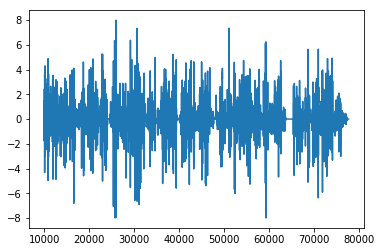

In [25]:
plt.plot(team.index.get_level_values(level=0),team['DFL-CLU-000N8Y','DFL-OBJ-000191','A']);

In [26]:
directionplayframe(10004,'DFL-CLU-000N8Y')

'left to right'

In [ ]:
#angriffsdrittel=float(35)             ##direction of play left to right
#angriffsdrittel=float(-35)             ##direction of play right to left

In [ ]:
startframe=[]
endframe=[]

In [115]:
columns = ["X","Y","A","D","S"]
Germany_id='DFL-CLU-000N8Y'
playerid='DFL-OBJ-0000O3'
Germany = positions.loc[
    # index (rows) - start:end
    :,
    # columns
    (
        Germany_id, # team level
        slice(None),   # player level
        columns    # position level
    )
]

In [55]:
positions.loc[
    # index (rows) - start:end
    100035:156666,
    # columns
    (
        Germany_id, # team level
        slice(None),   # player level
        columns    # position level
    )
]

Empty DataFrame
Columns: [(DFL-CLU-000N8Y, DFL-OBJ-000191, A), (DFL-CLU-000N8Y, DFL-OBJ-000191, X), (DFL-CLU-000N8Y, DFL-OBJ-000191, Y), (DFL-CLU-000N8Y, DFL-OBJ-0027G6, A), (DFL-CLU-000N8Y, DFL-OBJ-0027G6, X), (DFL-CLU-000N8Y, DFL-OBJ-0027G6, Y), (DFL-CLU-000N8Y, DFL-OBJ-0000I4, A), (DFL-CLU-000N8Y, DFL-OBJ-0000I4, X), (DFL-CLU-000N8Y, DFL-OBJ-0000I4, Y), (DFL-CLU-000N8Y, DFL-OBJ-0000SE, A), (DFL-CLU-000N8Y, DFL-OBJ-0000SE, X), (DFL-CLU-000N8Y, DFL-OBJ-0000SE, Y), (DFL-CLU-000N8Y, DFL-OBJ-0001HT, A), (DFL-CLU-000N8Y, DFL-OBJ-0001HT, X), (DFL-CLU-000N8Y, DFL-OBJ-0001HT, Y), (DFL-CLU-000N8Y, DFL-OBJ-0002AU, A), (DFL-CLU-000N8Y, DFL-OBJ-0002AU, X), (DFL-CLU-000N8Y, DFL-OBJ-0002AU, Y), (DFL-CLU-000N8Y, DFL-OBJ-0000OJ, A), (DFL-CLU-000N8Y, DFL-OBJ-0000OJ, X), (DFL-CLU-000N8Y, DFL-OBJ-0000OJ, Y), (DFL-CLU-000N8Y, DFL-OBJ-0000ZS, A), (DFL-CLU-000N8Y, DFL-OBJ-0000ZS, X), (DFL-CLU-000N8Y, DFL-OBJ-0000ZS, Y), (DFL-CLU-000N8Y, DFL-OBJ-0002F5, A), (DFL-CLU-000N8Y, DFL-OBJ-0002F5, X), (DFL-CLU-000N8Y, DFL-OBJ-0002F5, Y), (DFL-CLU-000N8Y, DFL-OBJ-0000O3, A), (DFL-CLU-000N8Y, DFL-OBJ-0000O3, X), (DFL-CLU-000N8Y, DFL-OBJ-0000O3, Y), (DFL-CLU-000N8Y, DFL-OBJ-00258K, A), (DFL-CLU-000N8Y, DFL-OBJ-00258K, X), (DFL-CLU-000N8Y, DFL-OBJ-00258K, Y)]
Index: []

[0 rows x 33 columns]

In [122]:
playerid='DFL-OBJ-0000O3'
dfa_first_speed=Germany[Germany_id,playerid,'S'][Germany[Germany_id,playerid,'S']>25]

In [57]:
positions.tail()

TeamId                                           BALL                 \
PersonId                               DFL-OBJ-0000XT                  
Position                                            A BallPossession   
N     T                                                                
77670 2019-06-11 21:32:08.400000+02:00            0.0              1   
77671 2019-06-11 21:32:08.440000+02:00            0.0              1   
77672 2019-06-11 21:32:08.480000+02:00            0.0              1   
77673 2019-06-11 21:32:08.520000+02:00            0.0              1   
77674 2019-06-11 21:32:08.560000+02:00            0.0              2   

TeamId                                                                      \
PersonId                                                                     
Position                               BallStatus      D   M      S      X   
N     T                                                                      
77670 2019-06-11 21:32:08.400000+02:00          1  61.84  46  56.97 -26.12   
77671 2019-06-11 21:32:08.440000+02:00          1  60.85  46  56.54 -25.57   
77672 2019-06-11 21:32:08.480000+02:00          1  60.72  46  55.53 -25.02   
77673 2019-06-11 21:32:08.520000+02:00          1  59.08  46  54.76 -24.46   
77674 2019-06-11 21:32:08.560000+02:00          0   0.00  46  54.35 -24.46   

TeamId                                              DFL-CLU-000N8Y  ...  \
PersonId                                            DFL-OBJ-000191  ...   
Position                                    Y     Z              A  ...   
N     T                                                             ...   
77670 2019-06-11 21:32:08.400000+02:00  16.14  0.17            0.0  ...   
77671 2019-06-11 21:32:08.440000+02:00  16.41  0.17            0.0  ...   
77672 2019-06-11 21:32:08.480000+02:00  16.66  0.16            0.0  ...   
77673 2019-06-11 21:32:08.520000+02:00  16.86  0.16            0.0  ...   
77674 2019-06-11 21:32:08.560000+02:00  16.86  0.00            0.0  ...   

TeamId                                 DFL-CLU-000N8Z                      \
PersonId                               DFL-OBJ-002FZZ                       
Position                                            M      S      X     Y   
N     T                                                                     
77670 2019-06-11 21:32:08.400000+02:00             46  16.42 -19.78 -4.57   
77671 2019-06-11 21:32:08.440000+02:00             46  16.72 -19.62 -4.46   
77672 2019-06-11 21:32:08.480000+02:00             46  17.20 -19.47 -4.36   
77673 2019-06-11 21:32:08.520000+02:00             46  17.62 -19.33 -4.26   
77674 2019-06-11 21:32:08.560000+02:00             46  18.11 -19.17 -4.14   

TeamId                                                                   \
PersonId                               DFL-OBJ-002G0B                     
Position                                            A      D   M      S   
N     T                                                                   
77670 2019-06-11 21:32:08.400000+02:00           0.92  23.09  46  20.69   
77671 2019-06-11 21:32:08.440000+02:00           0.90  23.09  46  20.84   
77672 2019-06-11 21:32:08.480000+02:00           0.85  23.09  46  20.85   
77673 2019-06-11 21:32:08.520000+02:00           0.76   0.00  46  21.00   
77674 2019-06-11 21:32:08.560000+02:00           0.62   0.00  46  21.15   

TeamId                                                
PersonId                                              
Position                                    X      Y  
N     T                                               
77670 2019-06-11 21:32:08.400000+02:00 -29.64 -13.80  
77671 2019-06-11 21:32:08.440000+02:00 -29.39 -13.80  
77672 2019-06-11 21:32:08.480000+02:00 -29.16 -13.79  
77673 2019-06-11 21:32:08.520000+02:00 -28.92 -13.79  
77674 2019-06-11 21:32:08.560000+02:00 -28.68 -13.77  

[5 rows x 141 columns]

In [109]:
###with A - acceleration
startframe=[]
endframe=[]
for idx, val in enumerate(dfa_first):
    if idx==0:
         startframe.append(dfa_first.index.get_level_values('N')[idx])
    if 0<idx and idx<dfa_first.count()-1:
        if float(dfa_first.index.get_level_values('N')[idx])-float(dfa_first.index.get_level_values('N')[idx-1]) > 50:
            endframe.append(dfa_first.index.get_level_values('N')[idx-1])
            startframe.append(dfa_first.index.get_level_values('N')[idx])
    if idx==dfa_first.count()-1:
        endframe.append(dfa_first.index.get_level_values('N')[idx])

In [129]:
###with S - speed
startframe=[]
endframe=[]
for idx, val in enumerate(dfa_first_speed):
    if idx==0:
         startframe.append(dfa_first_speed.index.get_level_values('N')[idx])
    if 0<idx and idx<dfa_first_speed.count()-1:
        if float(dfa_first_speed.index.get_level_values('N')[idx])-float(dfa_first_speed.index.get_level_values('N')[idx-1]) > 50:
            endframe.append(dfa_first_speed.index.get_level_values('N')[idx-1])
            startframe.append(dfa_first_speed.index.get_level_values('N')[idx])
    if idx==dfa_first_speed.count()-1:
        endframe.append(dfa_first_speed.index.get_level_values('N')[idx])

In [130]:
startframe

[23351, 27122, 27726, 38426, 50025, 58776, 65497, 68710, 73543]

In [131]:
endframe

[23406, 27151, 27740, 38465, 50076, 58901, 65503, 68712, 73565]

In [146]:
directionplayframe(70959,Germany_id)

'left to right'

In [68]:
endframe

[22838, 22987, 25668, 25796, 26012, 29181, 30669, 38661, 51146, 59206, 59294]

In [132]:
sprintframes = {'Startframe': startframe,
                 'Endframe': endframe}
sprintframesdf = pd.DataFrame(sprintframes,columns= ['Startframe', 'Endframe'])
print(sprintframesdf)

   Startframe  Endframe
0       23351     23406
1       27122     27151
2       27726     27740
3       38426     38465
4       50025     50076
5       58776     58901
6       65497     65503
7       68710     68712
8       73543     73565


In [142]:
german_players = Germany.columns.get_level_values(level=1).unique()

In [149]:
german_players[3]

'DFL-OBJ-0000SE'

In [143]:
amount=[]
for player in german_players: 
    dfa_first_speed=Germany[Germany_id,player,'S'][Germany[Germany_id,player,'S']>25]
    startframe=[]
    endframe=[]
    for idx, val in enumerate(dfa_first_speed):
        if idx==0:
             startframe.append(dfa_first_speed.index.get_level_values('N')[idx])
        if 0<idx and idx<dfa_first_speed.count()-1:
            if float(dfa_first_speed.index.get_level_values('N')[idx])-float(dfa_first_speed.index.get_level_values('N')[idx-1]) > 50:
                endframe.append(dfa_first_speed.index.get_level_values('N')[idx-1])
                startframe.append(dfa_first_speed.index.get_level_values('N')[idx])
        if idx==dfa_first_speed.count()-1:
            endframe.append(dfa_first_speed.index.get_level_values('N')[idx])
    amount.append(len(startframe))

In [144]:
amount

[4, 8, 0, 10, 4, 8, 4, 4, 4, 9, 7]

In [156]:
np.count_nonzero(Germany.loc[22987:25659,(Germany_id, playerid, ['X'])]>35)

425

In [139]:
Germany.loc[50025:50076,(Germany_id, playerid, ['X','S'])]

TeamId                                 DFL-CLU-000N8Y       
PersonId                               DFL-OBJ-0000O3       
Position                                            S      X
N     T                                                     
50025 2019-06-11 21:13:42.600000+02:00          25.07  26.11
50026 2019-06-11 21:13:42.640000+02:00          25.16  26.36
50027 2019-06-11 21:13:42.680000+02:00          25.22  26.64
50028 2019-06-11 21:13:42.720000+02:00          25.32  26.91
50029 2019-06-11 21:13:42.760000+02:00          25.36  27.17
50030 2019-06-11 21:13:42.800000+02:00          25.46  27.44
50031 2019-06-11 21:13:42.840000+02:00          25.49  27.71
50032 2019-06-11 21:13:42.880000+02:00          25.63  27.98
50033 2019-06-11 21:13:42.920000+02:00          25.80  28.25
50034 2019-06-11 21:13:42.960000+02:00          25.94  28.53
50035 2019-06-11 21:13:43+02:00                 25.87  28.79
50036 2019-06-11 21:13:43.040000+02:00          26.05  29.07
50037 2019-06-11 21:13:43.080000+02:00          26.09  29.35
50038 2019-06-11 21:13:43.120000+02:00          26.16  29.61
50039 2019-06-11 21:13:43.160000+02:00          26.16  29.89
50040 2019-06-11 21:13:43.200000+02:00          26.16  30.17
50041 2019-06-11 21:13:43.240000+02:00          26.34  30.45
50042 2019-06-11 21:13:43.280000+02:00          26.42  30.71
50043 2019-06-11 21:13:43.320000+02:00          26.59  30.99
50044 2019-06-11 21:13:43.360000+02:00          26.72  31.26
50045 2019-06-11 21:13:43.400000+02:00          26.90  31.52
50046 2019-06-11 21:13:43.440000+02:00          27.16  31.78
50047 2019-06-11 21:13:43.480000+02:00          27.20  32.07
50048 2019-06-11 21:13:43.520000+02:00          27.15  32.37
50049 2019-06-11 21:13:43.560000+02:00          27.06  32.66
50050 2019-06-11 21:13:43.600000+02:00          27.19  32.94
50051 2019-06-11 21:13:43.640000+02:00          27.23  33.24
50052 2019-06-11 21:13:43.680000+02:00          27.37  33.53
50053 2019-06-11 21:13:43.720000+02:00          27.38  33.82
50054 2019-06-11 21:13:43.760000+02:00          27.38  34.10
50055 2019-06-11 21:13:43.800000+02:00          27.32  34.37
50056 2019-06-11 21:13:43.840000+02:00          27.19  34.62
50057 2019-06-11 21:13:43.880000+02:00          27.17  34.89
50058 2019-06-11 21:13:43.920000+02:00          27.05  35.15
50059 2019-06-11 21:13:43.960000+02:00          27.03  35.42
50060 2019-06-11 21:13:44+02:00                 26.92  35.69
50061 2019-06-11 21:13:44.040000+02:00          26.81  35.95
50062 2019-06-11 21:13:44.080000+02:00          26.72  36.21
50063 2019-06-11 21:13:44.120000+02:00          26.71  36.46
50064 2019-06-11 21:13:44.160000+02:00          26.71  36.72
50065 2019-06-11 21:13:44.200000+02:00          26.60  36.97
50066 2019-06-11 21:13:44.240000+02:00          26.29  37.23
50067 2019-06-11 21:13:44.280000+02:00          26.29  37.48
50068 2019-06-11 21:13:44.320000+02:00          26.19  37.71
50069 2019-06-11 21:13:44.360000+02:00          26.19  37.94
50070 2019-06-11 21:13:44.400000+02:00          26.08  38.17
50071 2019-06-11 21:13:44.440000+02:00          26.10  38.42
50072 2019-06-11 21:13:44.480000+02:00          25.83  38.68
50073 2019-06-11 21:13:44.520000+02:00          25.59  38.93
50074 2019-06-11 21:13:44.560000+02:00          25.33  39.19
50075 2019-06-11 21:13:44.600000+02:00          25.08  39.45
50076 2019-06-11 21:13:44.640000+02:00          25.08  39.70